<a href="https://colab.research.google.com/github/Saoudyahya/fusion-with-attention/blob/main/Fusion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 29.2 MB/s eta 0:00:00


In [ ]:
import torch
from ultralytics import YOLO
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    VisionEncoderDecoderModel,
    ViTImageProcessor,
    ViTModel
)
import cv2
from PIL import Image
import numpy as np
import torch.nn as nn

# ========================================
# FIXED: Use YOLOv8 (compatible with ultralytics)
# ========================================
CAPTION_MODEL = "nlpconnect/vit-gpt2-image-captioning"
VIT_MODEL = "google/vit-base-patch16-224"
GPT2_MODEL = "gpt2"

class SpatialFeatureExtractor:
    """Extracts spatial features from YOLO detections"""

    def __init__(self, model_path):
        print(f"Loading YOLO model: {model_path}")
        self.model = YOLO(model_path)

    def extract_features(self, image_path):
        img = cv2.imread(image_path)
        results = self.model(img)

        detected_objects = []
        spatial_features_list = []

        img_height, img_width = img.shape[:2]

        for result in results[0].boxes.data.tolist():
            x1, y1, x2, y2, conf, cls = result
            label = self.model.names[int(cls)]

            # Normalize spatial coordinates
            center_x = ((x1 + x2) / 2) / img_width
            center_y = ((y1 + y2) / 2) / img_height
            width = (x2 - x1) / img_width
            height = (y2 - y1) / img_height
            area = width * height
            aspect_ratio = width / (height + 1e-6)

            spatial_feature = [center_x, center_y, width, height, area, aspect_ratio, conf, cls]
            spatial_features_list.append(spatial_feature)

            detected_objects.append({
                "label": label,
                "confidence": round(conf, 2),
                "bounding_box": [int(x1), int(y1), int(x2), int(y2)]
            })

        if spatial_features_list:
            spatial_features = torch.tensor(spatial_features_list, dtype=torch.float32)
        else:
            spatial_features = torch.zeros((1, 8), dtype=torch.float32)

        return img, detected_objects, spatial_features


class SemanticFeatureExtractor:
    """Extracts semantic features from ViT encoder"""

    def __init__(self):
        print(f"Loading ViT model: {VIT_MODEL}")
        self.vit_model = ViTModel.from_pretrained(VIT_MODEL)
        self.processor = ViTImageProcessor.from_pretrained(VIT_MODEL)
        self.vit_model.eval()

    def extract_features(self, image):
        if isinstance(image, np.ndarray):
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = Image.fromarray(image)

        inputs = self.processor(image, return_tensors="pt")

        with torch.no_grad():
            outputs = self.vit_model(**inputs)
            semantic_features = outputs.last_hidden_state[:, 0, :]  # CLS token [1, 768]
            patch_features = outputs.last_hidden_state  # All patches

        return semantic_features, patch_features


class MultiModalFusionModule(nn.Module):
    """
    Fusion module: Combines YOLO spatial + ViT semantic features
    Uses cross-attention mechanism
    """

    def __init__(self, spatial_dim=8, semantic_dim=768, hidden_dim=256, num_heads=4):
        super().__init__()

        # Project spatial features to hidden dimension
        self.spatial_projection = nn.Sequential(
            nn.Linear(spatial_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.1)
        )

        # Project semantic features to hidden dimension
        self.semantic_projection = nn.Sequential(
            nn.Linear(semantic_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.1)
        )

        # Cross-attention: spatial attends to semantic
        self.cross_attention = nn.MultiheadAttention(
            embed_dim=hidden_dim,
            num_heads=num_heads,
            dropout=0.1,
            batch_first=True
        )

        self.layer_norm1 = nn.LayerNorm(hidden_dim)
        self.layer_norm2 = nn.LayerNorm(hidden_dim)

        # Final fusion
        self.fusion_layer = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_dim, hidden_dim)
        )

    def forward(self, spatial_features, semantic_features):
        """
        Args:
            spatial_features: [N_objects, 8]
            semantic_features: [1, 768]
        Returns:
            fused_features: [1, 256]
            attention_weights: attention map
        """
        # Project to same dimension
        spatial_proj = self.spatial_projection(spatial_features)  # [N, 256]
        semantic_proj = self.semantic_projection(semantic_features)  # [1, 256]

        # Add batch dimension
        if spatial_proj.dim() == 2:
            spatial_proj = spatial_proj.unsqueeze(0)  # [1, N, 256]
        if semantic_proj.dim() == 2:
            semantic_proj = semantic_proj.unsqueeze(0)  # [1, 1, 256]

        # Cross-attention
        attn_output, attn_weights = self.cross_attention(
            query=spatial_proj,
            key=semantic_proj,
            value=semantic_proj
        )

        # Residual + norm
        spatial_attended = self.layer_norm1(spatial_proj + attn_output)

        # Global pooling
        spatial_pooled = torch.mean(spatial_attended, dim=1)  # [1, 256]
        semantic_norm = self.layer_norm2(semantic_proj.squeeze(1))  # [1, 256]

        # Concatenate and fuse
        concatenated = torch.cat([spatial_pooled, semantic_norm], dim=-1)  # [1, 512]
        fused_features = self.fusion_layer(concatenated)  # [1, 256]

        return fused_features, attn_weights


class EnhancedDescriptionGenerator:
    """GPT-2 generator with fused multi-modal features"""

    def __init__(self, fusion_hidden_dim=256):
        print(f"Loading GPT-2: {GPT2_MODEL}")
        self.tokenizer = AutoTokenizer.from_pretrained(GPT2_MODEL)
        self.model = AutoModelForCausalLM.from_pretrained(GPT2_MODEL)
        self.tokenizer.pad_token = self.tokenizer.eos_token

        # Adapter: fusion features -> GPT-2 embedding space
        self.feature_adapter = nn.Linear(fusion_hidden_dim, self.model.config.n_embd)

    def generate_description(self, detected_objects, caption, fused_features=None, use_fusion=True):
        if not detected_objects:
            return "No objects detected in the image."

        object_list = [f"{obj['label']} (conf: {obj['confidence']})" for obj in detected_objects]

        if use_fusion and fused_features is not None:
            prompt = f"Caption: {caption}\nObjects: {', '.join(object_list)}\nDescription:"
        else:
            prompt = (
                f"Image caption: {caption}\n\n"
                f"Detected objects: {', '.join(object_list)}.\n\n"
                "Based on the caption and detected objects, provide a detailed description "
                "of the scene, including spatial relationships and locations."
            )

        inputs = self.tokenizer(prompt, return_tensors="pt", padding=True, truncation=True)

        if use_fusion and fused_features is not None:
            # Use visual features
            adapted_features = self.feature_adapter(fused_features)
            input_embeds = self.model.transformer.wte(inputs.input_ids)
            combined_embeds = torch.cat([adapted_features.unsqueeze(1), input_embeds], dim=1)

            outputs = self.model.generate(
                inputs_embeds=combined_embeds,
                max_new_tokens=150,
                num_beams=5,
                temperature=0.8,
                top_p=0.9,
                no_repeat_ngram_size=2,
                pad_token_id=self.tokenizer.eos_token_id
            )
        else:
            # Baseline without fusion
            outputs = self.model.generate(
                inputs.input_ids,
                attention_mask=inputs.attention_mask,
                max_new_tokens=150,
                num_beams=5,
                no_repeat_ngram_size=2,
                pad_token_id=self.tokenizer.eos_token_id
            )

        return self.tokenizer.decode(outputs[0], skip_special_tokens=True)


class EnhancedVisionSystem:
    """Complete enhanced vision system"""

    def __init__(self, yolo_model="yolov8n.pt"):
        print("\n" + "="*80)
        print("INITIALIZING ENHANCED VISION SYSTEM")
        print("="*80 + "\n")

        self.spatial_extractor = SpatialFeatureExtractor(yolo_model)
        self.semantic_extractor = SemanticFeatureExtractor()
        self.fusion_module = MultiModalFusionModule()
        self.description_generator = EnhancedDescriptionGenerator()

        # Original captioning
        print(f"Loading caption model: {CAPTION_MODEL}")
        self.original_captioner = VisionEncoderDecoderModel.from_pretrained(CAPTION_MODEL)
        self.captioning_processor = ViTImageProcessor.from_pretrained(CAPTION_MODEL)
        self.captioning_tokenizer = AutoTokenizer.from_pretrained(CAPTION_MODEL)
        self.captioning_tokenizer.pad_token = self.captioning_tokenizer.eos_token

        print("\n✓ All systems initialized successfully!\n")

    def generate_caption(self, image):
        if isinstance(image, np.ndarray):
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = Image.fromarray(image)

        pixel_values = self.captioning_processor(image, return_tensors="pt").pixel_values

        with torch.no_grad():
            output_ids = self.original_captioner.generate(
                pixel_values,
                max_length=50,
                num_beams=4,
                early_stopping=True
            )

        return self.captioning_tokenizer.decode(output_ids[0], skip_special_tokens=True)

    def run_comparison(self, image_path):
        print("="*80)
        print(f"PROCESSING IMAGE: {image_path}")
        print("="*80 + "\n")

        # Step 1: Extract features
        print("📸 Step 1: Extracting features...")
        img, detected_objects, spatial_features = self.spatial_extractor.extract_features(image_path)
        semantic_features, _ = self.semantic_extractor.extract_features(img)
        caption = self.generate_caption(img)

        print(f"  ✓ Spatial features: {spatial_features.shape}")
        print(f"  ✓ Semantic features: {semantic_features.shape}")
        print(f"  ✓ Detected {len(detected_objects)} objects")
        print(f"  ✓ Caption: '{caption}'")

        # Step 2: Fuse features
        print("\n🔗 Step 2: Fusing multi-modal features...")
        fused_features, attention_weights = self.fusion_module(spatial_features, semantic_features)
        print(f"  ✓ Fused features: {fused_features.shape}")
        print(f"  ✓ Attention weights: {attention_weights.shape}")

        # Step 3: Generate baseline description (WITHOUT fusion)
        print("\n" + "="*80)
        print("📝 BASELINE DESCRIPTION (Without Fusion)")
        print("="*80)
        baseline_desc = self.description_generator.generate_description(
            detected_objects, caption, None, use_fusion=False
        )
        print(baseline_desc)

        # Step 4: Generate enhanced description (WITH fusion)
        print("\n" + "="*80)
        print("✨ ENHANCED DESCRIPTION (With Multi-Modal Fusion)")
        print("="*80)
        enhanced_desc = self.description_generator.generate_description(
            detected_objects, caption, fused_features, use_fusion=True
        )
        print(enhanced_desc)

        # Analysis
        print("\n" + "="*80)
        print("📊 ANALYSIS")
        print("="*80)
        print(f"\nDetected Objects:")
        for obj in detected_objects:
            print(f"  • {obj['label']}: {obj['confidence']:.2f} at {obj['bounding_box']}")

        print(f"\nAttention Statistics:")
        print(f"  • Mean: {attention_weights.mean().item():.4f}")
        print(f"  • Max: {attention_weights.max().item():.4f}")
        print(f"  • Std: {attention_weights.std().item():.4f}")

        return {
            "image": img,
            "caption": caption,
            "detected_objects": detected_objects,
            "spatial_features": spatial_features,
            "semantic_features": semantic_features,
            "fused_features": fused_features,
            "attention_weights": attention_weights,
            "baseline_description": baseline_desc,
            "enhanced_description": enhanced_desc
        }


# ========================================
# USAGE EXAMPLE
# ========================================
if __name__ == "__main__":
    # YOLOv8 will auto-download on first use
    # Options: yolov8n.pt (nano), yolov8s.pt (small), yolov8m.pt (medium)

    system = EnhancedVisionSystem("yolov8n.pt")  # Using YOLOv8-nano (fastest)

    # Change this to your image path
    results = system.run_comparison("/content/pexels-joshsorenson-139303.jpg")

    print("\n" + "="*80)
    print("✅ PROCESSING COMPLETE!")
    print("="*80)


INITIALIZING ENHANCED VISION SYSTEM

Loading YOLO model: yolov8n.pt
Loading ViT model: google/vit-base-patch16-224


Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Loading GPT-2: gpt2
Loading caption model: nlpconnect/vit-gpt2-image-captioning

✓ All systems initialized successfully!

PROCESSING IMAGE: /content/pexels-joshsorenson-139303.jpg

📸 Step 1: Extracting features...

0: 448x640 17 persons, 8 cars, 1 traffic light, 458.0ms
Speed: 10.2ms preprocess, 458.0ms inference, 4.7ms postprocess per image at shape (1, 3, 448, 640)


The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.
You may ignore this warning if your `pad_token_id` (50256) is identical to the `bos_token_id` (50256), `eos_token_id` (50256), or the `sep_token_id` (None), and your input is not padded.


  ✓ Spatial features: torch.Size([26, 8])
  ✓ Semantic features: torch.Size([1, 768])
  ✓ Detected 26 objects
  ✓ Caption: 'a city street filled with lots of traffic '

🔗 Step 2: Fusing multi-modal features...
  ✓ Fused features: torch.Size([1, 256])
  ✓ Attention weights: torch.Size([1, 26, 1])

📝 BASELINE DESCRIPTION (Without Fusion)


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Image caption: a city street filled with lots of traffic 

Detected objects: car (conf: 0.91), car (conf: 0.88), car (conf: 0.69), person (conf: 0.68), person (conf: 0.67), person (conf: 0.66), car (conf: 0.59), person (conf: 0.58), car (conf: 0.52), traffic light (conf: 0.5), person (conf: 0.5), person (conf: 0.47), car (conf: 0.35), person (conf: 0.35), person (conf: 0.35), person (conf: 0.35), car (conf: 0.33), car (conf: 0.3), person (conf: 0.3), person (conf: 0.3), person (conf: 0.28), person (conf: 0.28), person (conf: 0.27), person (conf: 0.27), person (conf: 0.27), person (conf: 0.26).

Based on the caption and detected objects, provide a detailed description of the scene, including spatial relationships and locations. If you have any questions or concerns, please contact the police or Crime Stoppers anonymously on 0800 555 111 or visit www.crimestoppers.org.uk.

✨ ENHANCED DESCRIPTION (With Multi-Modal Fusion)
 a city street filled with lots of traffic 
Objects: car (conf: 0.9


INITIALIZING ENHANCED VISION SYSTEM

Loading YOLO model: yolov8n.pt
Loading ViT model: google/vit-base-patch16-224


Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Loading GPT-2: gpt2
Loading caption model: nlpconnect/vit-gpt2-image-captioning

✓ All systems initialized successfully!

PROCESSING IMAGE: /content/pexels-joshsorenson-139303.jpg

📸 Step 1: Extracting features...

0: 448x640 17 persons, 8 cars, 1 traffic light, 317.6ms
Speed: 16.7ms preprocess, 317.6ms inference, 2.3ms postprocess per image at shape (1, 3, 448, 640)
  ✓ Spatial features: torch.Size([26, 8])
  ✓ Semantic features: torch.Size([1, 768])
  ✓ Detected 26 objects
  ✓ Caption: 'a city street filled with lots of traffic '

🔗 Step 2: Fusing multi-modal features...
  ✓ Fused features: torch.Size([1, 256])
  ✓ Attention weights: torch.Size([1, 26, 1])

📝 BASELINE DESCRIPTION (Without Fusion)
Image caption: a city street filled with lots of traffic 

Detected objects: car (conf: 0.91), car (conf: 0.88), car (conf: 0.69), person (conf: 0.68), person (conf: 0.67), person (conf: 0.66), car (conf: 0.59), person (conf: 0.58), car (conf: 0.52), traffic light (conf: 0.5), person (conf: 

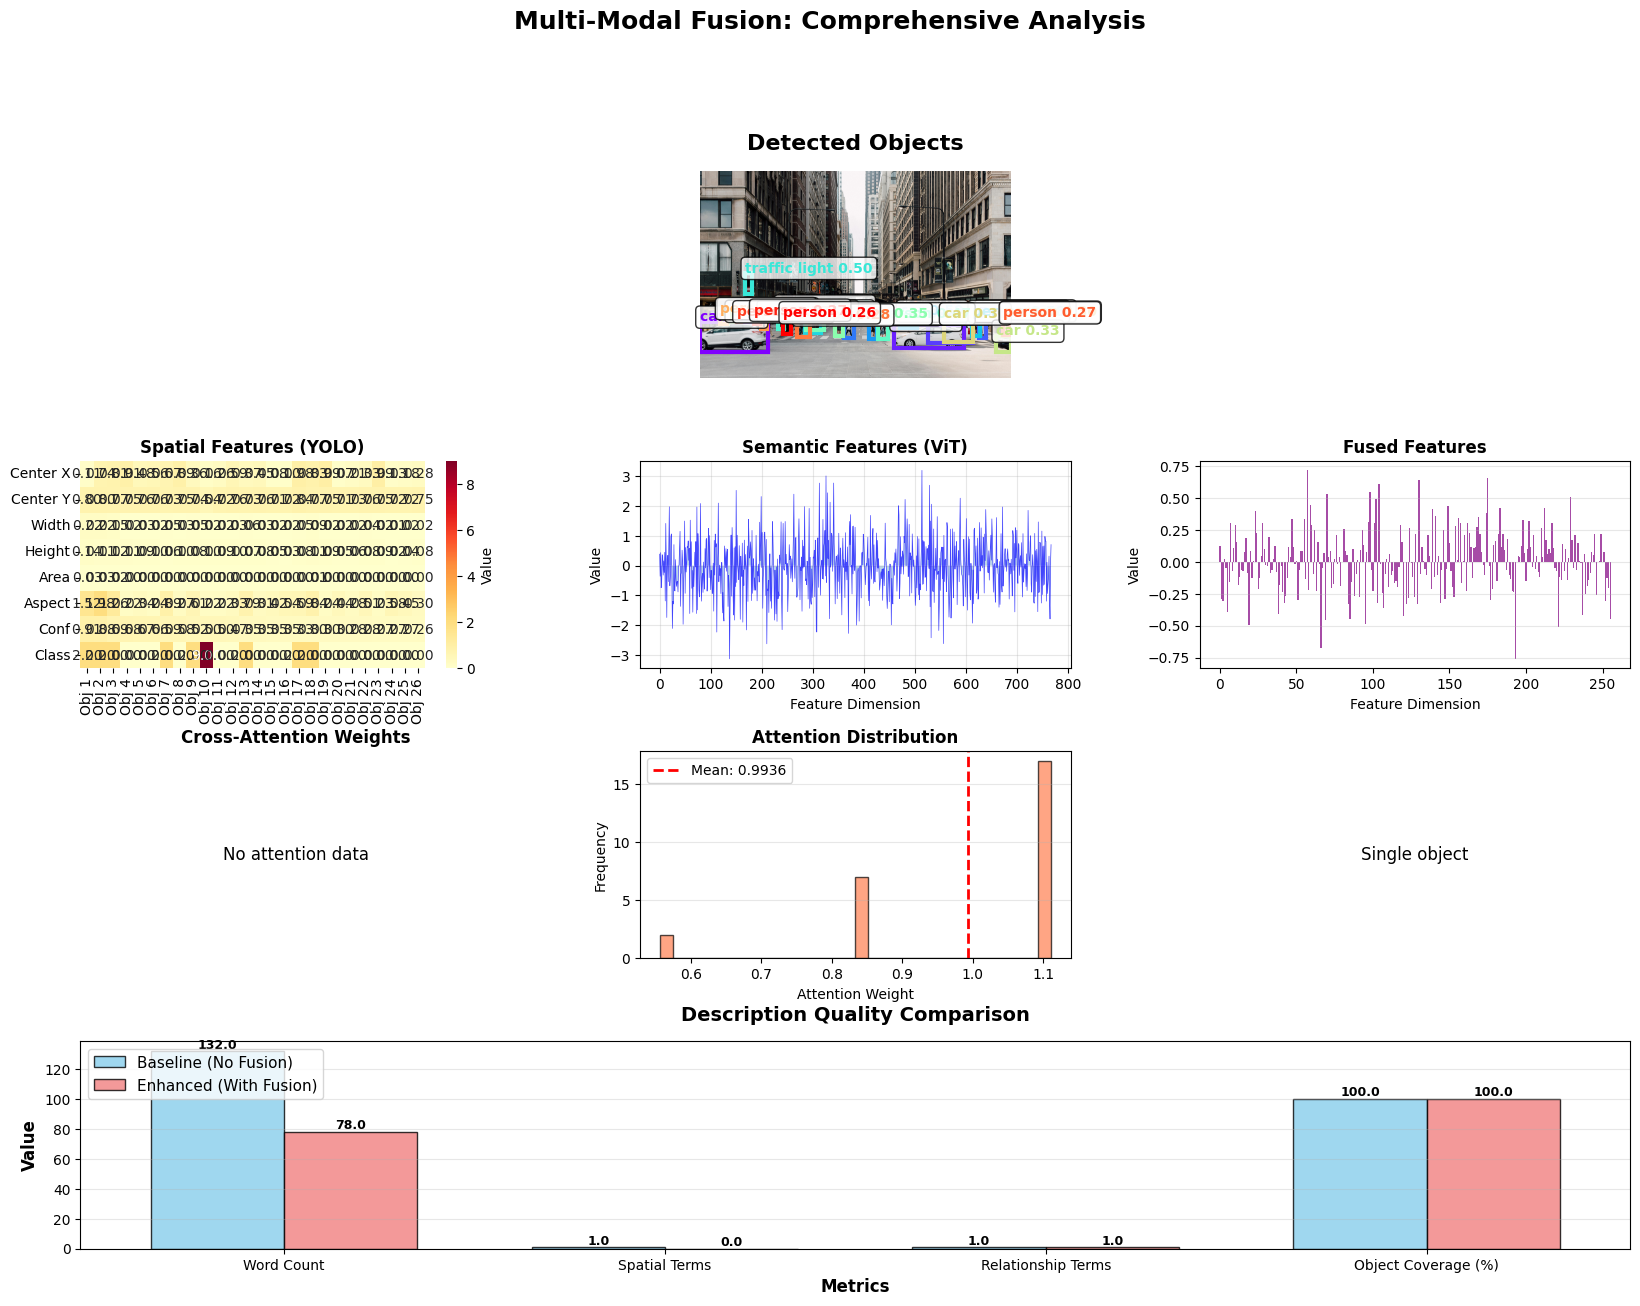

/tmp/ipython-input-1322708294.py:470: UserWarning: Glyph 128221 (\N{MEMO}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0.03, 1, 0.96])
/tmp/ipython-input-1322708294.py:470: UserWarning: Glyph 10024 (\N{SPARKLES}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0.03, 1, 0.96])
/tmp/ipython-input-1322708294.py:471: UserWarning: Glyph 128221 (\N{MEMO}) missing from font(s) DejaVu Sans.
  plt.savefig('text_comparison.png', dpi=300, bbox_inches='tight')
/tmp/ipython-input-1322708294.py:471: UserWarning: Glyph 10024 (\N{SPARKLES}) missing from font(s) DejaVu Sans.
  plt.savefig('text_comparison.png', dpi=300, bbox_inches='tight')


✓ Saved: text_comparison.png


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128221 (\N{MEMO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 10024 (\N{SPARKLES}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


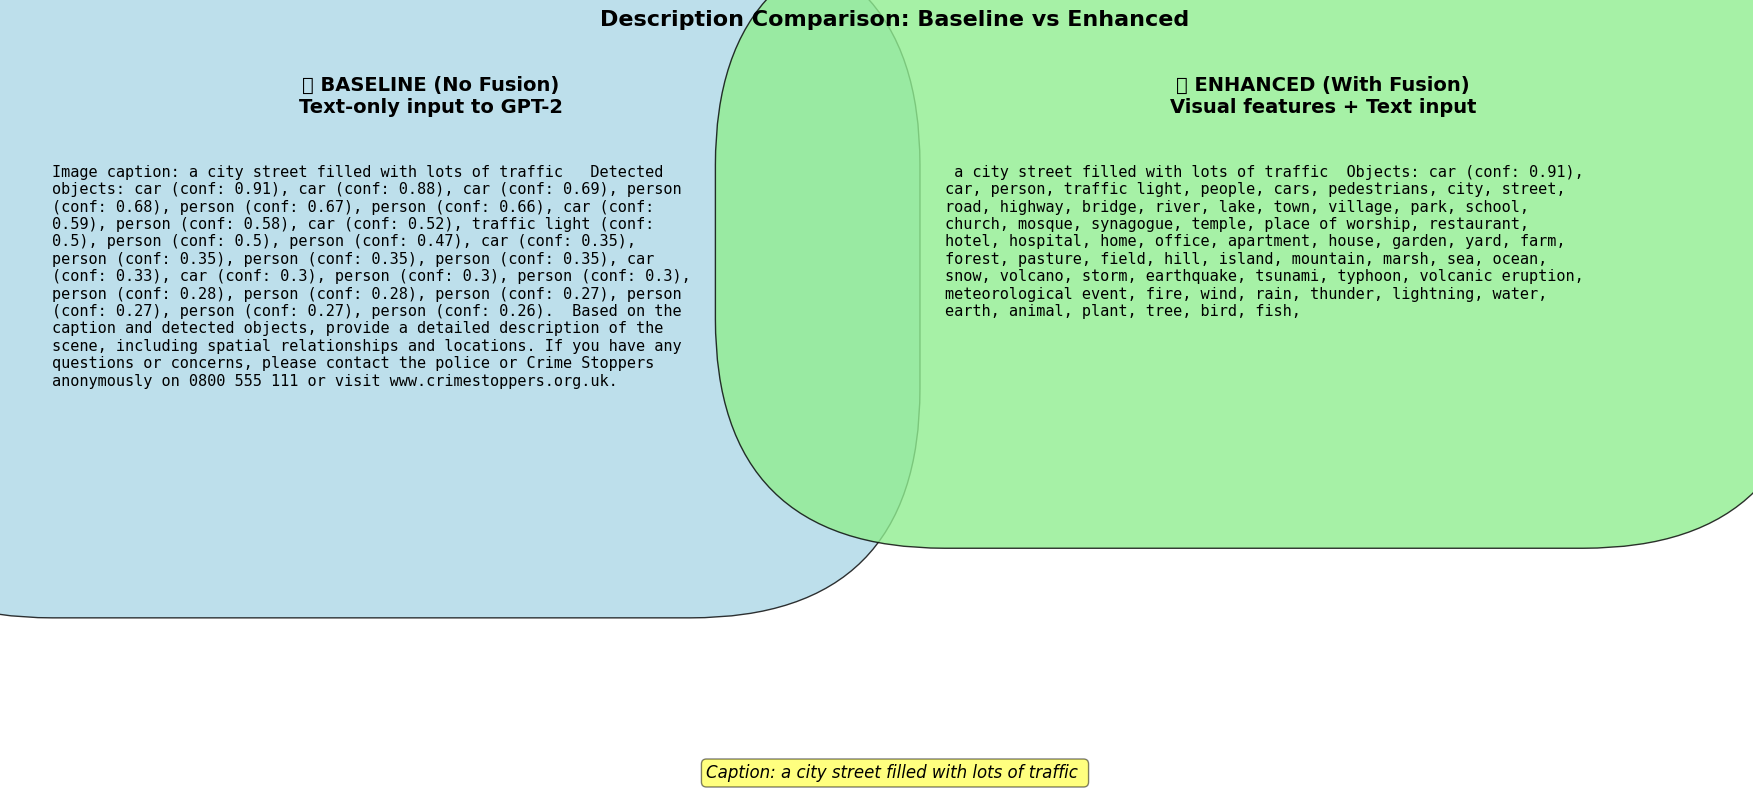

/tmp/ipython-input-1322708294.py:544: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1322708294.py:545: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  plt.savefig('architecture_diagram.png', dpi=300, bbox_inches='tight')


✓ Saved: architecture_diagram.png


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


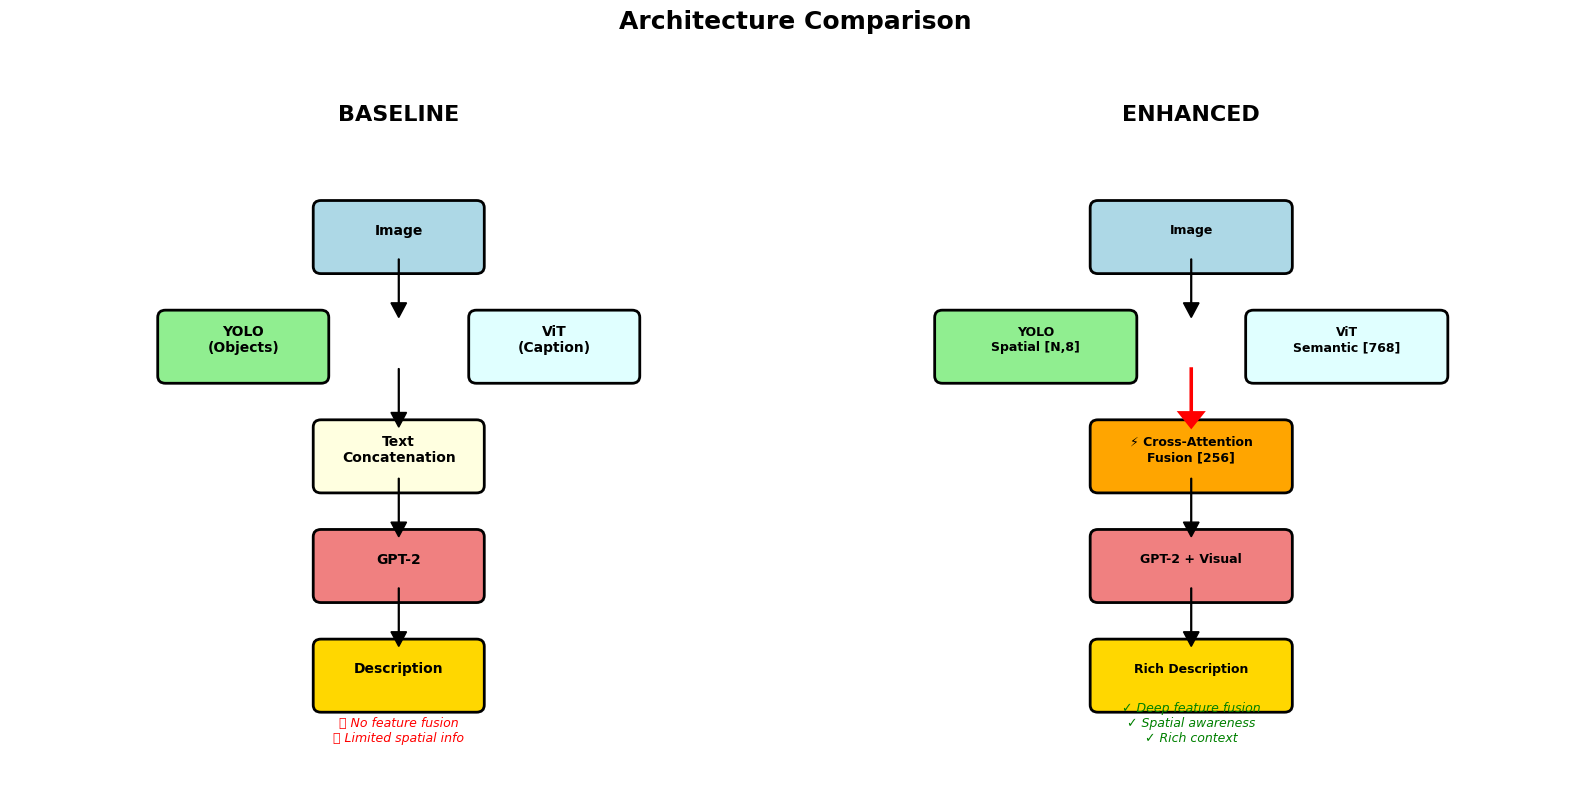


✅ PROCESSING COMPLETE!

📁 Generated files:
  • comprehensive_comparison.png - Full feature and metric analysis
  • text_comparison.png - Side-by-side description comparison
  • architecture_diagram.png - System architecture comparison


In [ ]:
import torch
from ultralytics import YOLO
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    VisionEncoderDecoderModel,
    ViTImageProcessor,
    ViTModel
)
import cv2
from PIL import Image
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.gridspec import GridSpec
import seaborn as sns
from textwrap import wrap

# ========================================
# FIXED: Use YOLOv8 (compatible with ultralytics)
# ========================================
CAPTION_MODEL = "nlpconnect/vit-gpt2-image-captioning"
VIT_MODEL = "google/vit-base-patch16-224"
GPT2_MODEL = "gpt2"

class SpatialFeatureExtractor:
    """Extracts spatial features from YOLO detections"""

    def __init__(self, model_path):
        print(f"Loading YOLO model: {model_path}")
        self.model = YOLO(model_path)

    def extract_features(self, image_path):
        img = cv2.imread(image_path)
        results = self.model(img)

        detected_objects = []
        spatial_features_list = []

        img_height, img_width = img.shape[:2]

        for result in results[0].boxes.data.tolist():
            x1, y1, x2, y2, conf, cls = result
            label = self.model.names[int(cls)]

            # Normalize spatial coordinates
            center_x = ((x1 + x2) / 2) / img_width
            center_y = ((y1 + y2) / 2) / img_height
            width = (x2 - x1) / img_width
            height = (y2 - y1) / img_height
            area = width * height
            aspect_ratio = width / (height + 1e-6)

            spatial_feature = [center_x, center_y, width, height, area, aspect_ratio, conf, cls]
            spatial_features_list.append(spatial_feature)

            detected_objects.append({
                "label": label,
                "confidence": round(conf, 2),
                "bounding_box": [int(x1), int(y1), int(x2), int(y2)]
            })

        if spatial_features_list:
            spatial_features = torch.tensor(spatial_features_list, dtype=torch.float32)
        else:
            spatial_features = torch.zeros((1, 8), dtype=torch.float32)

        return img, detected_objects, spatial_features


class SemanticFeatureExtractor:
    """Extracts semantic features from ViT encoder"""

    def __init__(self):
        print(f"Loading ViT model: {VIT_MODEL}")
        self.vit_model = ViTModel.from_pretrained(VIT_MODEL)
        self.processor = ViTImageProcessor.from_pretrained(VIT_MODEL)
        self.vit_model.eval()

    def extract_features(self, image):
        if isinstance(image, np.ndarray):
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = Image.fromarray(image)

        inputs = self.processor(image, return_tensors="pt")

        with torch.no_grad():
            outputs = self.vit_model(**inputs)
            semantic_features = outputs.last_hidden_state[:, 0, :]  # CLS token [1, 768]
            patch_features = outputs.last_hidden_state  # All patches

        return semantic_features, patch_features


class MultiModalFusionModule(nn.Module):
    """
    Fusion module: Combines YOLO spatial + ViT semantic features
    Uses cross-attention mechanism
    """

    def __init__(self, spatial_dim=8, semantic_dim=768, hidden_dim=256, num_heads=4):
        super().__init__()

        # Project spatial features to hidden dimension
        self.spatial_projection = nn.Sequential(
            nn.Linear(spatial_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.1)
        )

        # Project semantic features to hidden dimension
        self.semantic_projection = nn.Sequential(
            nn.Linear(semantic_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.1)
        )

        # Cross-attention: spatial attends to semantic
        self.cross_attention = nn.MultiheadAttention(
            embed_dim=hidden_dim,
            num_heads=num_heads,
            dropout=0.1,
            batch_first=True
        )

        self.layer_norm1 = nn.LayerNorm(hidden_dim)
        self.layer_norm2 = nn.LayerNorm(hidden_dim)

        # Final fusion
        self.fusion_layer = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_dim, hidden_dim)
        )

    def forward(self, spatial_features, semantic_features):
        """
        Args:
            spatial_features: [N_objects, 8]
            semantic_features: [1, 768]
        Returns:
            fused_features: [1, 256]
            attention_weights: attention map
        """
        # Project to same dimension
        spatial_proj = self.spatial_projection(spatial_features)  # [N, 256]
        semantic_proj = self.semantic_projection(semantic_features)  # [1, 256]

        # Add batch dimension
        if spatial_proj.dim() == 2:
            spatial_proj = spatial_proj.unsqueeze(0)  # [1, N, 256]
        if semantic_proj.dim() == 2:
            semantic_proj = semantic_proj.unsqueeze(0)  # [1, 1, 256]

        # Cross-attention
        attn_output, attn_weights = self.cross_attention(
            query=spatial_proj,
            key=semantic_proj,
            value=semantic_proj
        )

        # Residual + norm
        spatial_attended = self.layer_norm1(spatial_proj + attn_output)

        # Global pooling
        spatial_pooled = torch.mean(spatial_attended, dim=1)  # [1, 256]
        semantic_norm = self.layer_norm2(semantic_proj.squeeze(1))  # [1, 256]

        # Concatenate and fuse
        concatenated = torch.cat([spatial_pooled, semantic_norm], dim=-1)  # [1, 512]
        fused_features = self.fusion_layer(concatenated)  # [1, 256]

        return fused_features, attn_weights


class EnhancedDescriptionGenerator:
    """GPT-2 generator with fused multi-modal features"""

    def __init__(self, fusion_hidden_dim=256):
        print(f"Loading GPT-2: {GPT2_MODEL}")
        self.tokenizer = AutoTokenizer.from_pretrained(GPT2_MODEL)
        self.model = AutoModelForCausalLM.from_pretrained(GPT2_MODEL)
        self.tokenizer.pad_token = self.tokenizer.eos_token

        # Adapter: fusion features -> GPT-2 embedding space
        self.feature_adapter = nn.Linear(fusion_hidden_dim, self.model.config.n_embd)

    def generate_description(self, detected_objects, caption, fused_features=None, use_fusion=True):
        if not detected_objects:
            return "No objects detected in the image."

        object_list = [f"{obj['label']} (conf: {obj['confidence']})" for obj in detected_objects]

        if use_fusion and fused_features is not None:
            prompt = f"Caption: {caption}\nObjects: {', '.join(object_list)}\nDescription:"
        else:
            prompt = (
                f"Image caption: {caption}\n\n"
                f"Detected objects: {', '.join(object_list)}.\n\n"
                "Based on the caption and detected objects, provide a detailed description "
                "of the scene, including spatial relationships and locations."
            )

        inputs = self.tokenizer(prompt, return_tensors="pt", padding=True, truncation=True)

        if use_fusion and fused_features is not None:
            # Use visual features
            adapted_features = self.feature_adapter(fused_features)
            input_embeds = self.model.transformer.wte(inputs.input_ids)
            combined_embeds = torch.cat([adapted_features.unsqueeze(1), input_embeds], dim=1)

            outputs = self.model.generate(
                inputs_embeds=combined_embeds,
                max_new_tokens=150,
                num_beams=5,
                temperature=0.8,
                top_p=0.9,
                no_repeat_ngram_size=2,
                pad_token_id=self.tokenizer.eos_token_id
            )
        else:
            # Baseline without fusion
            outputs = self.model.generate(
                inputs.input_ids,
                attention_mask=inputs.attention_mask,
                max_new_tokens=150,
                num_beams=5,
                no_repeat_ngram_size=2,
                pad_token_id=self.tokenizer.eos_token_id
            )

        return self.tokenizer.decode(outputs[0], skip_special_tokens=True)


class ComparisonVisualizer:
    """Visualize the comparison between baseline and enhanced system"""

    @staticmethod
    def analyze_description(description, detected_objects):
        """Analyze description quality metrics"""
        metrics = {
            'length': len(description),
            'word_count': len(description.split()),
            'spatial_terms': 0,
            'relationship_terms': 0,
            'object_coverage': 0,
            'mentioned_objects': []
        }

        # Spatial terms
        spatial_terms = ['left', 'right', 'front', 'behind', 'near', 'next to', 'beside',
                        'above', 'below', 'center', 'middle', 'corner', 'edge', 'top', 'bottom',
                        'between', 'around', 'across', 'along', 'through']
        desc_lower = description.lower()
        metrics['spatial_terms'] = sum(1 for term in spatial_terms if term in desc_lower)

        # Relationship terms
        relationship_terms = ['with', 'alongside', 'between', 'among', 'near', 'close to',
                             'far from', 'adjacent', 'next to', 'by', 'in front', 'behind']
        metrics['relationship_terms'] = sum(1 for term in relationship_terms if term in desc_lower)

        # Object coverage
        for obj in detected_objects:
            if obj['label'].lower() in desc_lower:
                metrics['mentioned_objects'].append(obj['label'])

        metrics['object_coverage'] = len(metrics['mentioned_objects']) / len(detected_objects) if detected_objects else 0

        return metrics

    @staticmethod
    def plot_comprehensive_comparison(results):
        """Create comprehensive visualization of the comparison"""

        fig = plt.figure(figsize=(20, 14))
        gs = GridSpec(4, 3, figure=fig, hspace=0.4, wspace=0.3)

        img = cv2.cvtColor(results['image'], cv2.COLOR_BGR2RGB)
        detected_objects = results['detected_objects']

        # ============ ROW 1: IMAGE WITH DETECTIONS ============
        ax1 = fig.add_subplot(gs[0, :])
        ax1.imshow(img)
        ax1.set_title('Detected Objects', fontsize=16, fontweight='bold', pad=15)
        ax1.axis('off')

        # Draw bounding boxes
        colors = plt.cm.rainbow(np.linspace(0, 1, len(detected_objects)))
        for obj, color in zip(detected_objects, colors):
            x1, y1, x2, y2 = obj['bounding_box']
            rect = patches.Rectangle((x1, y1), x2-x1, y2-y1,
                                    linewidth=3, edgecolor=color, facecolor='none')
            ax1.add_patch(rect)
            ax1.text(x1, y1-10, f"{obj['label']} {obj['confidence']:.2f}",
                    fontsize=10, color=color, fontweight='bold',
                    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

        # ============ ROW 2: FEATURE VISUALIZATIONS ============

        # Spatial features heatmap
        ax2 = fig.add_subplot(gs[1, 0])
        spatial_data = results['spatial_features'].numpy()
        if spatial_data.shape[0] > 1:
            feature_names = ['Center X', 'Center Y', 'Width', 'Height', 'Area', 'Aspect', 'Conf', 'Class']
            sns.heatmap(spatial_data.T, annot=True, fmt='.2f', cmap='YlOrRd',
                       yticklabels=feature_names, xticklabels=[f"Obj {i+1}" for i in range(len(detected_objects))],
                       ax=ax2, cbar_kws={'label': 'Value'})
            ax2.set_title('Spatial Features (YOLO)', fontsize=12, fontweight='bold')
        else:
            ax2.text(0.5, 0.5, 'No spatial features', ha='center', va='center', fontsize=12)
            ax2.set_title('Spatial Features (YOLO)', fontsize=12, fontweight='bold')
            ax2.axis('off')

        # Semantic features visualization
        ax3 = fig.add_subplot(gs[1, 1])
        semantic_data = results['semantic_features'][0].numpy()
        ax3.plot(semantic_data, linewidth=0.5, alpha=0.7, color='blue')
        ax3.fill_between(range(len(semantic_data)), semantic_data, alpha=0.3)
        ax3.set_title('Semantic Features (ViT)', fontsize=12, fontweight='bold')
        ax3.set_xlabel('Feature Dimension', fontsize=10)
        ax3.set_ylabel('Value', fontsize=10)
        ax3.grid(True, alpha=0.3)

        # Fused features visualization
        ax4 = fig.add_subplot(gs[1, 2])
        fused_data = results['fused_features'][0].detach().numpy()
        ax4.bar(range(len(fused_data)), fused_data, color='purple', alpha=0.7)
        ax4.set_title('Fused Features', fontsize=12, fontweight='bold')
        ax4.set_xlabel('Feature Dimension', fontsize=10)
        ax4.set_ylabel('Value', fontsize=10)
        ax4.grid(True, alpha=0.3, axis='y')

        # ============ ROW 3: ATTENTION WEIGHTS ============

        ax5 = fig.add_subplot(gs[2, 0])
        attn = results['attention_weights'][0].mean(dim=0).detach().numpy()  # Average across heads

        if attn.shape[0] > 1:
            sns.heatmap(attn, annot=True, fmt='.3f', cmap='RdYlGn',
                       xticklabels=['Semantic'],
                       yticklabels=[f"{obj['label']}" for obj in detected_objects],
                       ax=ax5, cbar_kws={'label': 'Attention Weight'})
            ax5.set_title('Cross-Attention Weights\n(Objects → Scene Context)',
                         fontsize=12, fontweight='bold')
        else:
            ax5.text(0.5, 0.5, 'No attention data', ha='center', va='center', fontsize=12)
            ax5.set_title('Cross-Attention Weights', fontsize=12, fontweight='bold')
            ax5.axis('off')

        # Attention statistics
        ax6 = fig.add_subplot(gs[2, 1])
        attn_flat = results['attention_weights'].flatten().detach().numpy()
        ax6.hist(attn_flat, bins=30, color='coral', alpha=0.7, edgecolor='black')
        ax6.axvline(attn_flat.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {attn_flat.mean():.4f}')
        ax6.set_title('Attention Distribution', fontsize=12, fontweight='bold')
        ax6.set_xlabel('Attention Weight', fontsize=10)
        ax6.set_ylabel('Frequency', fontsize=10)
        ax6.legend()
        ax6.grid(True, alpha=0.3, axis='y')

        # Top attended objects
        ax7 = fig.add_subplot(gs[2, 2])
        if attn.shape[0] > 1:
            avg_attn_per_obj = attn.mean(axis=1)
            object_labels = [obj['label'] for obj in detected_objects]
            sorted_indices = np.argsort(avg_attn_per_obj)[::-1]

            bars = ax7.barh([object_labels[i] for i in sorted_indices],
                           [avg_attn_per_obj[i] for i in sorted_indices],
                           color=plt.cm.viridis(np.linspace(0, 1, len(sorted_indices))))
            ax7.set_title('Average Attention per Object', fontsize=12, fontweight='bold')
            ax7.set_xlabel('Attention Weight', fontsize=10)
            ax7.grid(True, alpha=0.3, axis='x')
        else:
            ax7.text(0.5, 0.5, 'Single object', ha='center', va='center', fontsize=12)
            ax7.axis('off')

        # ============ ROW 4: METRICS COMPARISON ============

        baseline_metrics = ComparisonVisualizer.analyze_description(
            results['baseline_description'], detected_objects
        )
        enhanced_metrics = ComparisonVisualizer.analyze_description(
            results['enhanced_description'], detected_objects
        )

        ax8 = fig.add_subplot(gs[3, :])

        metrics_names = ['Word Count', 'Spatial Terms', 'Relationship Terms', 'Object Coverage (%)']
        baseline_values = [
            baseline_metrics['word_count'],
            baseline_metrics['spatial_terms'],
            baseline_metrics['relationship_terms'],
            baseline_metrics['object_coverage'] * 100
        ]
        enhanced_values = [
            enhanced_metrics['word_count'],
            enhanced_metrics['spatial_terms'],
            enhanced_metrics['relationship_terms'],
            enhanced_metrics['object_coverage'] * 100
        ]

        x = np.arange(len(metrics_names))
        width = 0.35

        bars1 = ax8.bar(x - width/2, baseline_values, width, label='Baseline (No Fusion)',
                       color='skyblue', alpha=0.8, edgecolor='black')
        bars2 = ax8.bar(x + width/2, enhanced_values, width, label='Enhanced (With Fusion)',
                       color='lightcoral', alpha=0.8, edgecolor='black')

        # Add value labels on bars
        for bars in [bars1, bars2]:
            for bar in bars:
                height = bar.get_height()
                ax8.text(bar.get_x() + bar.get_width()/2., height,
                        f'{height:.1f}',
                        ha='center', va='bottom', fontsize=9, fontweight='bold')

        ax8.set_xlabel('Metrics', fontsize=12, fontweight='bold')
        ax8.set_ylabel('Value', fontsize=12, fontweight='bold')
        ax8.set_title('Description Quality Comparison', fontsize=14, fontweight='bold', pad=15)
        ax8.set_xticks(x)
        ax8.set_xticklabels(metrics_names, fontsize=10)
        ax8.legend(fontsize=11, loc='upper left')
        ax8.grid(True, alpha=0.3, axis='y')

        plt.suptitle('Multi-Modal Fusion: Comprehensive Analysis',
                    fontsize=18, fontweight='bold', y=0.995)

        plt.savefig('comprehensive_comparison.png', dpi=300, bbox_inches='tight')
        print("\n✓ Saved: comprehensive_comparison.png")
        plt.show()

    @staticmethod
    def plot_text_comparison(results):
        """Create side-by-side text comparison"""

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))

        # Baseline description
        baseline_text = '\n'.join(wrap(results['baseline_description'], 70))
        ax1.text(0.05, 0.95, baseline_text, transform=ax1.transAxes,
                fontsize=11, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8, pad=15),
                family='monospace')
        ax1.set_title('📝 BASELINE (No Fusion)\nText-only input to GPT-2',
                     fontsize=14, fontweight='bold', pad=15)
        ax1.axis('off')

        # Enhanced description
        enhanced_text = '\n'.join(wrap(results['enhanced_description'], 70))
        ax2.text(0.05, 0.95, enhanced_text, transform=ax2.transAxes,
                fontsize=11, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.8, pad=15),
                family='monospace')
        ax2.set_title('✨ ENHANCED (With Fusion)\nVisual features + Text input',
                     fontsize=14, fontweight='bold', pad=15)
        ax2.axis('off')

        # Add caption
        fig.text(0.5, 0.02, f"Caption: {results['caption']}",
                ha='center', fontsize=12, style='italic',
                bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.5))

        plt.suptitle('Description Comparison: Baseline vs Enhanced',
                    fontsize=16, fontweight='bold', y=0.98)

        plt.tight_layout(rect=[0, 0.03, 1, 0.96])
        plt.savefig('text_comparison.png', dpi=300, bbox_inches='tight')
        print("✓ Saved: text_comparison.png")
        plt.show()

    @staticmethod
    def plot_architecture_diagram():
        """Simple architecture comparison diagram"""

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

        # Baseline architecture
        ax1.text(0.5, 0.9, 'BASELINE', ha='center', fontsize=16, fontweight='bold')

        boxes_baseline = [
            (0.5, 0.75, 'Image', 'lightblue'),
            (0.3, 0.6, 'YOLO\n(Objects)', 'lightgreen'),
            (0.7, 0.6, 'ViT\n(Caption)', 'lightcyan'),
            (0.5, 0.45, 'Text\nConcatenation', 'lightyellow'),
            (0.5, 0.3, 'GPT-2', 'lightcoral'),
            (0.5, 0.15, 'Description', 'gold')
        ]

        for x, y, text, color in boxes_baseline:
            ax1.add_patch(patches.FancyBboxPatch((x-0.1, y-0.05), 0.2, 0.08,
                                                 boxstyle="round,pad=0.01",
                                                 facecolor=color, edgecolor='black', linewidth=2))
            ax1.text(x, y, text, ha='center', va='center', fontsize=10, fontweight='bold')

        # Arrows
        ax1.arrow(0.5, 0.71, 0, -0.06, head_width=0.02, head_length=0.02, fc='black', ec='black')
        ax1.arrow(0.5, 0.56, 0, -0.06, head_width=0.02, head_length=0.02, fc='black', ec='black')
        ax1.arrow(0.5, 0.41, 0, -0.06, head_width=0.02, head_length=0.02, fc='black', ec='black')
        ax1.arrow(0.5, 0.26, 0, -0.06, head_width=0.02, head_length=0.02, fc='black', ec='black')

        ax1.text(0.5, 0.05, '❌ No feature fusion\n❌ Limited spatial info',
                ha='center', fontsize=9, style='italic', color='red')

        ax1.set_xlim(0, 1)
        ax1.set_ylim(0, 1)
        ax1.axis('off')

        # Enhanced architecture
        ax2.text(0.5, 0.9, 'ENHANCED', ha='center', fontsize=16, fontweight='bold')

        boxes_enhanced = [
            (0.5, 0.75, 'Image', 'lightblue'),
            (0.3, 0.6, 'YOLO\nSpatial [N,8]', 'lightgreen'),
            (0.7, 0.6, 'ViT\nSemantic [768]', 'lightcyan'),
            (0.5, 0.45, '⚡ Cross-Attention\nFusion [256]', 'orange'),
            (0.5, 0.3, 'GPT-2 + Visual', 'lightcoral'),
            (0.5, 0.15, 'Rich Description', 'gold')
        ]

        for x, y, text, color in boxes_enhanced:
            ax2.add_patch(patches.FancyBboxPatch((x-0.12, y-0.05), 0.24, 0.08,
                                                 boxstyle="round,pad=0.01",
                                                 facecolor=color, edgecolor='black', linewidth=2))
            ax2.text(x, y, text, ha='center', va='center', fontsize=9, fontweight='bold')

        # Arrows (thicker for fusion)
        ax2.arrow(0.5, 0.71, 0, -0.06, head_width=0.02, head_length=0.02, fc='black', ec='black')
        ax2.arrow(0.5, 0.56, 0, -0.06, head_width=0.03, head_length=0.02, fc='red', ec='red', linewidth=2)
        ax2.arrow(0.5, 0.41, 0, -0.06, head_width=0.02, head_length=0.02, fc='black', ec='black')
        ax2.arrow(0.5, 0.26, 0, -0.06, head_width=0.02, head_length=0.02, fc='black', ec='black')

        ax2.text(0.5, 0.05, '✓ Deep feature fusion\n✓ Spatial awareness\n✓ Rich context',
                ha='center', fontsize=9, style='italic', color='green')

        ax2.set_xlim(0, 1)
        ax2.set_ylim(0, 1)
        ax2.axis('off')

        plt.suptitle('Architecture Comparison', fontsize=18, fontweight='bold')
        plt.tight_layout()
        plt.savefig('architecture_diagram.png', dpi=300, bbox_inches='tight')
        print("✓ Saved: architecture_diagram.png")
        plt.show()


class EnhancedVisionSystem:
    """Complete enhanced vision system"""

    def __init__(self, yolo_model="yolov8n.pt"):
        print("\n" + "="*80)
        print("INITIALIZING ENHANCED VISION SYSTEM")
        print("="*80 + "\n")

        self.spatial_extractor = SpatialFeatureExtractor(yolo_model)
        self.semantic_extractor = SemanticFeatureExtractor()
        self.fusion_module = MultiModalFusionModule()
        self.description_generator = EnhancedDescriptionGenerator()

        # Original captioning
        print(f"Loading caption model: {CAPTION_MODEL}")
        self.original_captioner = VisionEncoderDecoderModel.from_pretrained(CAPTION_MODEL)
        self.captioning_processor = ViTImageProcessor.from_pretrained(CAPTION_MODEL)
        self.captioning_tokenizer = AutoTokenizer.from_pretrained(CAPTION_MODEL)
        self.captioning_tokenizer.pad_token = self.captioning_tokenizer.eos_token

        print("\n✓ All systems initialized successfully!\n")

    def generate_caption(self, image):
        if isinstance(image, np.ndarray):
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = Image.fromarray(image)

        pixel_values = self.captioning_processor(image, return_tensors="pt").pixel_values

        with torch.no_grad():
            output_ids = self.original_captioner.generate(
                pixel_values,
                max_length=50,
                num_beams=4,
                early_stopping=True
            )

        return self.captioning_tokenizer.decode(output_ids[0], skip_special_tokens=True)

    def run_comparison(self, image_path):
        print("="*80)
        print(f"PROCESSING IMAGE: {image_path}")
        print("="*80 + "\n")

        # Step 1: Extract features
        print("📸 Step 1: Extracting features...")
        img, detected_objects, spatial_features = self.spatial_extractor.extract_features(image_path)
        semantic_features, _ = self.semantic_extractor.extract_features(img)
        caption = self.generate_caption(img)

        print(f"  ✓ Spatial features: {spatial_features.shape}")
        print(f"  ✓ Semantic features: {semantic_features.shape}")
        print(f"  ✓ Detected {len(detected_objects)} objects")
        print(f"  ✓ Caption: '{caption}'")

        # Step 2: Fuse features
        print("\n🔗 Step 2: Fusing multi-modal features...")
        fused_features, attention_weights = self.fusion_module(spatial_features, semantic_features)
        print(f"  ✓ Fused features: {fused_features.shape}")
        print(f"  ✓ Attention weights: {attention_weights.shape}")

        # Step 3: Generate baseline description (WITHOUT fusion)
        print("\n" + "="*80)
        print("📝 BASELINE DESCRIPTION (Without Fusion)")
        print("="*80)
        baseline_desc = self.description_generator.generate_description(
            detected_objects, caption, None, use_fusion=False
        )
        print(baseline_desc)

        # Step 4: Generate enhanced description (WITH fusion)
        print("\n" + "="*80)
        print("✨ ENHANCED DESCRIPTION (With Multi-Modal Fusion)")
        print("="*80)
        enhanced_desc = self.description_generator.generate_description(
            detected_objects, caption, fused_features, use_fusion=True
        )
        print(enhanced_desc)

        # Analysis
        print("\n" + "="*80)
        print("📊 ANALYSIS")
        print("="*80)
        print(f"\nDetected Objects:")
        for obj in detected_objects:
            print(f"  • {obj['label']}: {obj['confidence']:.2f} at {obj['bounding_box']}")

        print(f"\nAttention Statistics:")
        print(f"  • Mean: {attention_weights.mean().item():.4f}")
        print(f"  • Max: {attention_weights.max().item():.4f}")
        print(f"  • Std: {attention_weights.std().item():.4f}")

        results = {
            "image": img,
            "caption": caption,
            "detected_objects": detected_objects,
            "spatial_features": spatial_features,
            "semantic_features": semantic_features,
            "fused_features": fused_features,
            "attention_weights": attention_weights,
            "baseline_description": baseline_desc,
            "enhanced_description": enhanced_desc
        }

        # Generate visualizations
        print("\n" + "="*80)
        print("📊 GENERATING VISUALIZATIONS")
        print("="*80)

        ComparisonVisualizer.plot_comprehensive_comparison(results)
        ComparisonVisualizer.plot_text_comparison(results)
        ComparisonVisualizer.plot_architecture_diagram()

        return results


# ========================================
# USAGE EXAMPLE
# ========================================
if __name__ == "__main__":
    system = EnhancedVisionSystem("yolov8n.pt")
    results = system.run_comparison("/content/pexels-joshsorenson-139303.jpg")

    print("\n" + "="*80)
    print("✅ PROCESSING COMPLETE!")
    print("="*80)
    print("\n📁 Generated files:")
    print("  • comprehensive_comparison.png - Full feature and metric analysis")
    print("  • text_comparison.png - Side-by-side description comparison")
    print("  • architecture_diagram.png - System architecture comparison")


INITIALIZING ENHANCED VISION SYSTEM

Loading YOLO model: yolov8n.pt
  ⏱️  YOLO Model Loading: 172.24ms (0.172s)
Loading ViT model: google/vit-base-patch16-224


Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  ⏱️  ViT Model Loading: 764.68ms (0.765s)
Loading GPT-2: gpt2
  ⏱️  GPT-2 Model Loading: 1393.67ms (1.394s)
Loading caption model: nlpconnect/vit-gpt2-image-captioning
  ⏱️  Caption Model Loading: 4424.59ms (4.425s)

✓ All systems initialized successfully!

PROCESSING IMAGE: /content/pexels-joshsorenson-139303.jpg

📸 Step 1: Extracting features...

0: 448x640 17 persons, 8 cars, 1 traffic light, 268.4ms
Speed: 8.1ms preprocess, 268.4ms inference, 1.9ms postprocess per image at shape (1, 3, 448, 640)
  ⏱️  YOLO Feature Extraction: 760.43ms (0.760s)
  ⏱️  ViT Feature Extraction: 964.77ms (0.965s)
  ⏱️  Caption Generation: 3057.73ms (3.058s)
  ✓ Spatial features: torch.Size([26, 8])
  ✓ Semantic features: torch.Size([1, 768])
  ✓ Detected 26 objects
  ✓ Caption: 'a city street filled with lots of traffic '

🔗 Step 2: Fusing multi-modal features...
  ⏱️  Feature Fusion: 2.50ms (0.002s)
  ✓ Fused features: torch.Size([1, 256])
  ✓ Attention weights: torch.Size([1, 26, 1])

📝 BASELINE DESCR

/tmp/ipython-input-3375154829.py:600: UserWarning: Glyph 9201 (\N{STOPWATCH}) missing from font(s) DejaVu Sans.
  plt.savefig('comprehensive_comparison.png', dpi=300, bbox_inches='tight')



✓ Saved: comprehensive_comparison.png


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9201 (\N{STOPWATCH}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


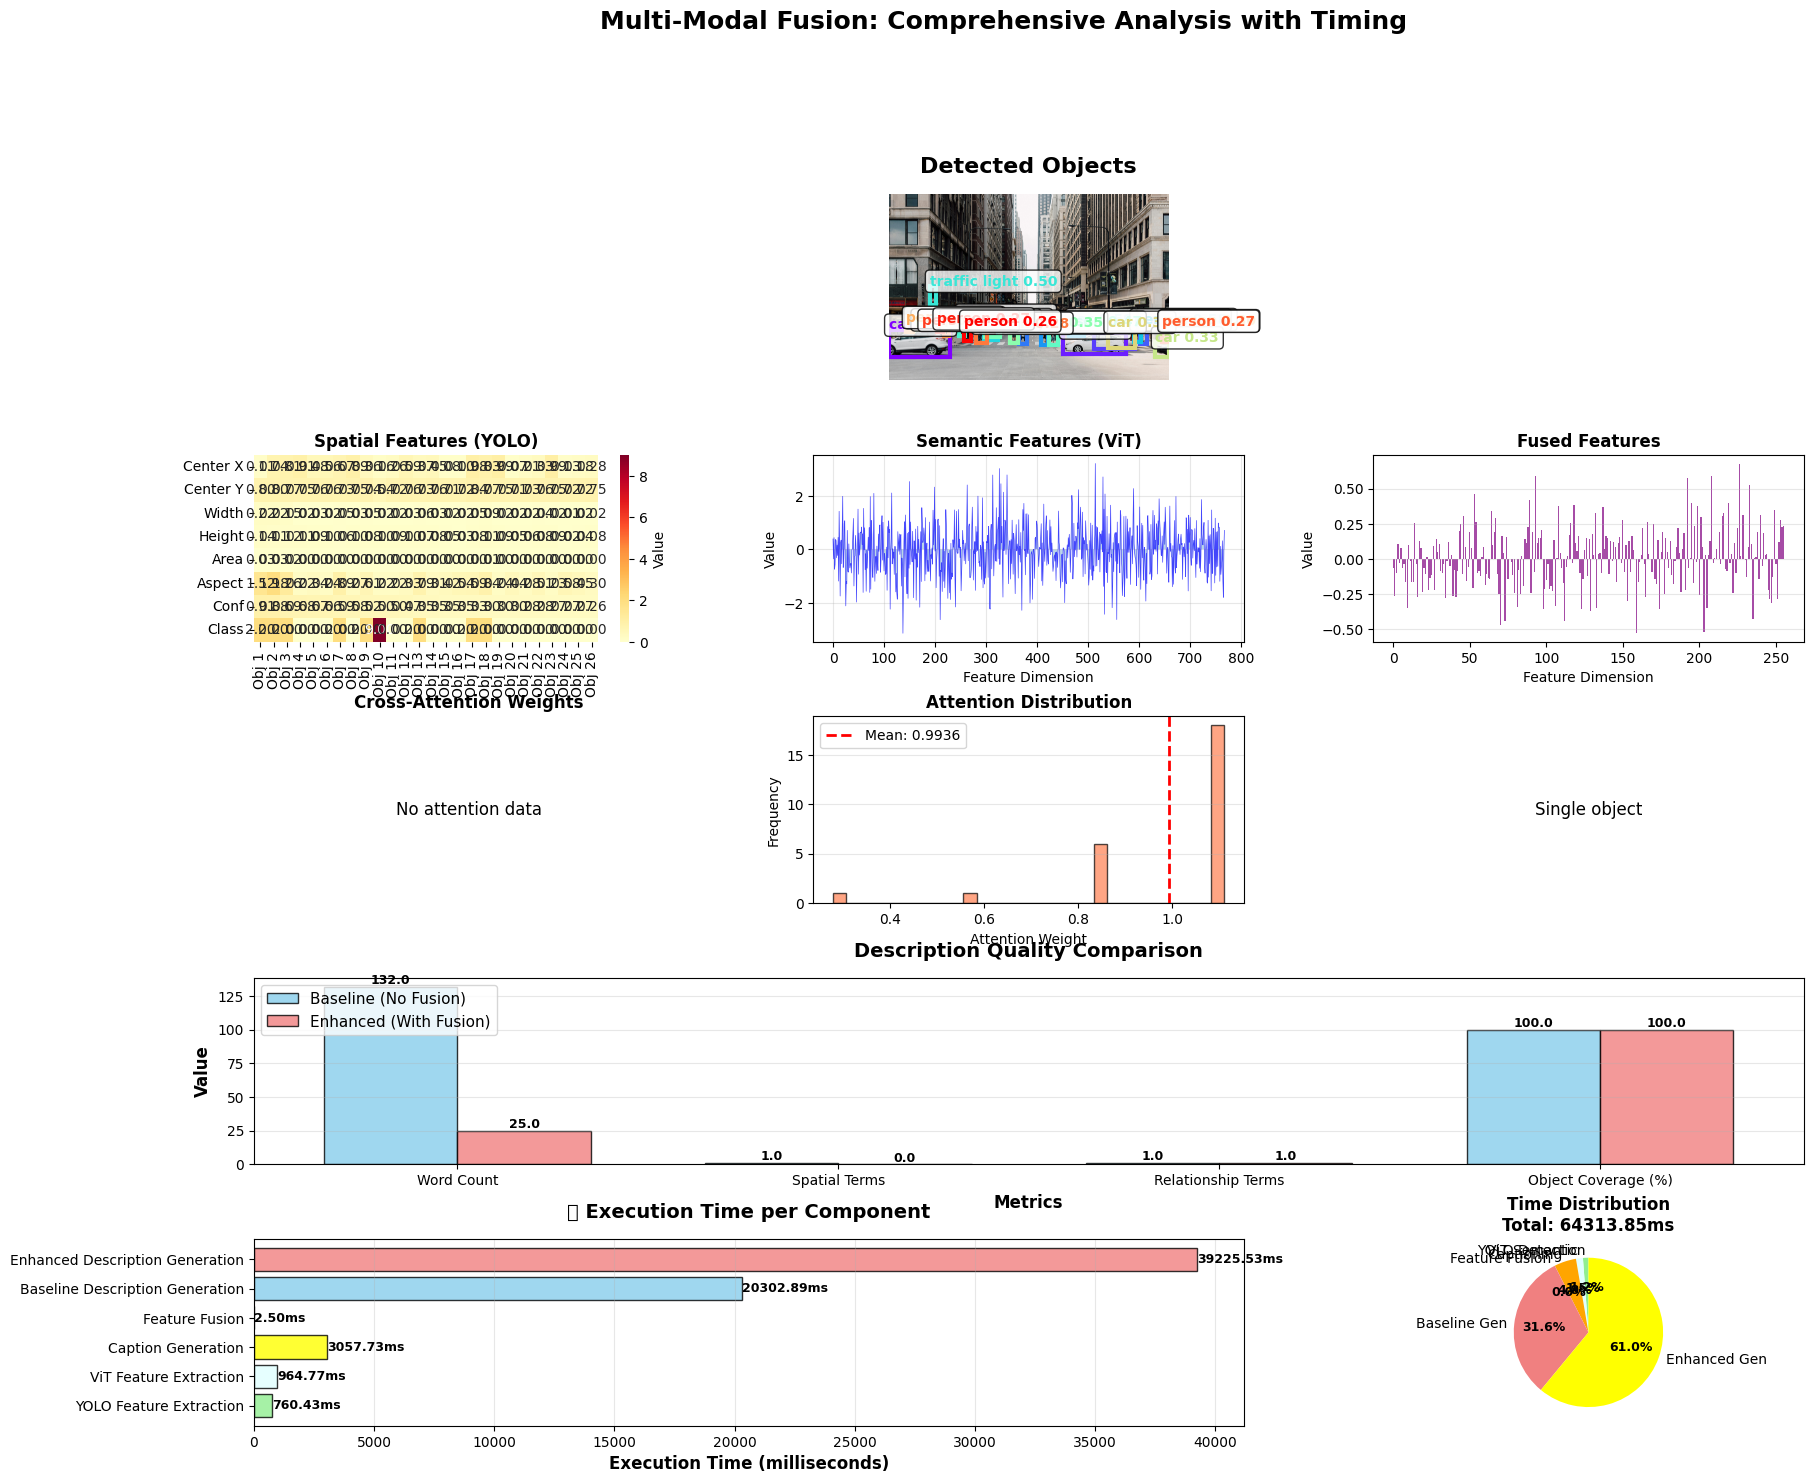

/tmp/ipython-input-3375154829.py:638: UserWarning: Glyph 128221 (\N{MEMO}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0.03, 1, 0.96])
/tmp/ipython-input-3375154829.py:638: UserWarning: Glyph 10024 (\N{SPARKLES}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0.03, 1, 0.96])
/tmp/ipython-input-3375154829.py:639: UserWarning: Glyph 128221 (\N{MEMO}) missing from font(s) DejaVu Sans.
  plt.savefig('text_comparison.png', dpi=300, bbox_inches='tight')
/tmp/ipython-input-3375154829.py:639: UserWarning: Glyph 10024 (\N{SPARKLES}) missing from font(s) DejaVu Sans.
  plt.savefig('text_comparison.png', dpi=300, bbox_inches='tight')


✓ Saved: text_comparison.png


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128221 (\N{MEMO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 10024 (\N{SPARKLES}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


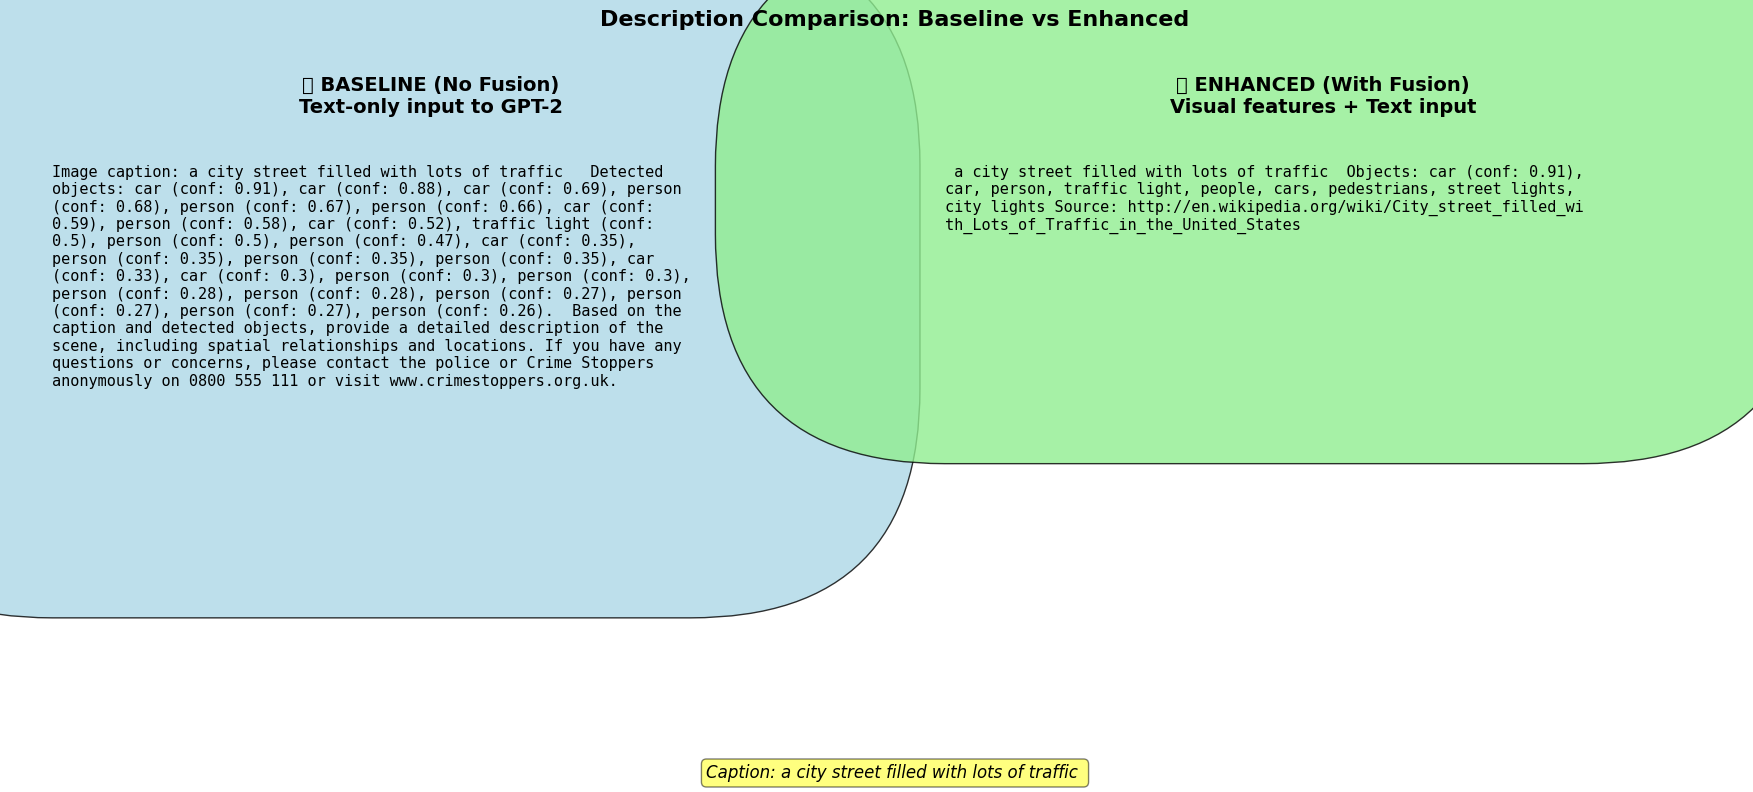

/tmp/ipython-input-3375154829.py:712: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3375154829.py:713: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  plt.savefig('architecture_diagram.png', dpi=300, bbox_inches='tight')


✓ Saved: architecture_diagram.png


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


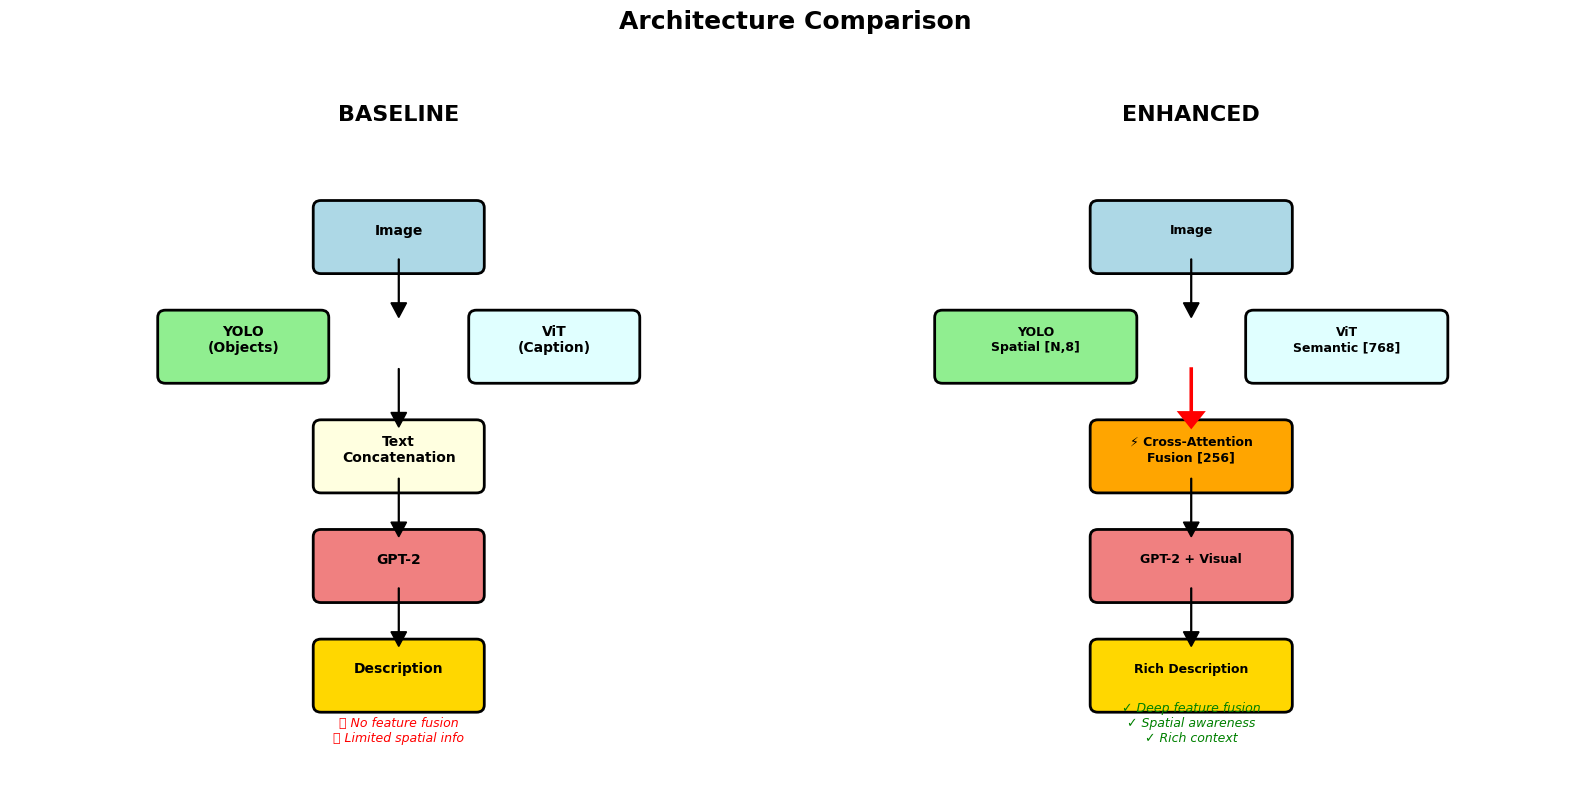

  ⏱️  Visualization Generation: 13265.84ms (13.266s)

✅ PROCESSING COMPLETE!

⏱️  Total execution time: 84518.65ms (84.519s)

📁 Generated files:
  • comprehensive_comparison.png - Full analysis with timing breakdown
  • text_comparison.png - Side-by-side descriptions
  • architecture_diagram.png - System comparison


In [ ]:
import torch
from ultralytics import YOLO
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    VisionEncoderDecoderModel,
    ViTImageProcessor,
    ViTModel
)
import cv2
from PIL import Image
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.gridspec import GridSpec
import seaborn as sns
from textwrap import wrap
import time
from collections import defaultdict

# ========================================
# FIXED: Use YOLOv8 (compatible with ultralytics)
# ========================================
CAPTION_MODEL = "nlpconnect/vit-gpt2-image-captioning"
VIT_MODEL = "google/vit-base-patch16-224"
GPT2_MODEL = "gpt2"


class Timer:
    """Context manager for timing code blocks"""

    def __init__(self, name="", verbose=True):
        self.name = name
        self.verbose = verbose
        self.elapsed = 0

    def __enter__(self):
        self.start = time.time()
        return self

    def __exit__(self, *args):
        self.end = time.time()
        self.elapsed = self.end - self.start
        if self.verbose:
            print(f"  ⏱️  {self.name}: {self.elapsed*1000:.2f}ms ({self.elapsed:.3f}s)")


class TimingTracker:
    """Track and display execution timings"""

    def __init__(self):
        self.timings = defaultdict(list)
        self.current_timings = {}

    def add_timing(self, name, elapsed_time):
        """Add a timing measurement"""
        self.timings[name].append(elapsed_time)
        self.current_timings[name] = elapsed_time

    def get_summary(self):
        """Get summary of all timings"""
        summary = {}
        for name, times in self.timings.items():
            summary[name] = {
                'mean': np.mean(times),
                'min': np.min(times),
                'max': np.max(times),
                'total': np.sum(times),
                'count': len(times)
            }
        return summary

    def print_summary(self):
        """Print formatted timing summary"""
        print("\n" + "="*80)
        print("⏱️  EXECUTION TIME SUMMARY")
        print("="*80)

        total_time = 0
        timing_data = []

        for name, elapsed in self.current_timings.items():
            total_time += elapsed
            timing_data.append((name, elapsed))

        # Sort by time
        timing_data.sort(key=lambda x: x[1], reverse=True)

        print(f"\n{'Component':<40} {'Time (ms)':<12} {'Time (s)':<10} {'%':<8}")
        print("-" * 80)

        for name, elapsed in timing_data:
            percentage = (elapsed / total_time * 100) if total_time > 0 else 0
            print(f"{name:<40} {elapsed*1000:>10.2f}ms {elapsed:>8.3f}s {percentage:>6.1f}%")

        print("-" * 80)
        print(f"{'TOTAL':<40} {total_time*1000:>10.2f}ms {total_time:>8.3f}s {100:>6.1f}%")
        print("="*80)


class SpatialFeatureExtractor:
    """Extracts spatial features from YOLO detections"""

    def __init__(self, model_path, timer_tracker=None):
        print(f"Loading YOLO model: {model_path}")
        with Timer("YOLO Model Loading", verbose=True):
            self.model = YOLO(model_path)
        self.timer_tracker = timer_tracker

    def extract_features(self, image_path):
        with Timer("YOLO Feature Extraction") as t:
            img = cv2.imread(image_path)
            results = self.model(img)

            detected_objects = []
            spatial_features_list = []

            img_height, img_width = img.shape[:2]

            for result in results[0].boxes.data.tolist():
                x1, y1, x2, y2, conf, cls = result
                label = self.model.names[int(cls)]

                # Normalize spatial coordinates
                center_x = ((x1 + x2) / 2) / img_width
                center_y = ((y1 + y2) / 2) / img_height
                width = (x2 - x1) / img_width
                height = (y2 - y1) / img_height
                area = width * height
                aspect_ratio = width / (height + 1e-6)

                spatial_feature = [center_x, center_y, width, height, area, aspect_ratio, conf, cls]
                spatial_features_list.append(spatial_feature)

                detected_objects.append({
                    "label": label,
                    "confidence": round(conf, 2),
                    "bounding_box": [int(x1), int(y1), int(x2), int(y2)]
                })

            if spatial_features_list:
                spatial_features = torch.tensor(spatial_features_list, dtype=torch.float32)
            else:
                spatial_features = torch.zeros((1, 8), dtype=torch.float32)

        if self.timer_tracker:
            self.timer_tracker.add_timing("YOLO Feature Extraction", t.elapsed)

        return img, detected_objects, spatial_features


class SemanticFeatureExtractor:
    """Extracts semantic features from ViT encoder"""

    def __init__(self, timer_tracker=None):
        print(f"Loading ViT model: {VIT_MODEL}")
        with Timer("ViT Model Loading", verbose=True):
            self.vit_model = ViTModel.from_pretrained(VIT_MODEL)
            self.processor = ViTImageProcessor.from_pretrained(VIT_MODEL)
            self.vit_model.eval()
        self.timer_tracker = timer_tracker

    def extract_features(self, image):
        with Timer("ViT Feature Extraction") as t:
            if isinstance(image, np.ndarray):
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = Image.fromarray(image)

            inputs = self.processor(image, return_tensors="pt")

            with torch.no_grad():
                outputs = self.vit_model(**inputs)
                semantic_features = outputs.last_hidden_state[:, 0, :]  # CLS token [1, 768]
                patch_features = outputs.last_hidden_state  # All patches

        if self.timer_tracker:
            self.timer_tracker.add_timing("ViT Feature Extraction", t.elapsed)

        return semantic_features, patch_features


class MultiModalFusionModule(nn.Module):
    """
    Fusion module: Combines YOLO spatial + ViT semantic features
    Uses cross-attention mechanism
    """

    def __init__(self, spatial_dim=8, semantic_dim=768, hidden_dim=256, num_heads=4):
        super().__init__()

        # Project spatial features to hidden dimension
        self.spatial_projection = nn.Sequential(
            nn.Linear(spatial_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.1)
        )

        # Project semantic features to hidden dimension
        self.semantic_projection = nn.Sequential(
            nn.Linear(semantic_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.1)
        )

        # Cross-attention: spatial attends to semantic
        self.cross_attention = nn.MultiheadAttention(
            embed_dim=hidden_dim,
            num_heads=num_heads,
            dropout=0.1,
            batch_first=True
        )

        self.layer_norm1 = nn.LayerNorm(hidden_dim)
        self.layer_norm2 = nn.LayerNorm(hidden_dim)

        # Final fusion
        self.fusion_layer = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_dim, hidden_dim)
        )

    def forward(self, spatial_features, semantic_features):
        """
        Args:
            spatial_features: [N_objects, 8]
            semantic_features: [1, 768]
        Returns:
            fused_features: [1, 256]
            attention_weights: attention map
        """
        # Project to same dimension
        spatial_proj = self.spatial_projection(spatial_features)  # [N, 256]
        semantic_proj = self.semantic_projection(semantic_features)  # [1, 256]

        # Add batch dimension
        if spatial_proj.dim() == 2:
            spatial_proj = spatial_proj.unsqueeze(0)  # [1, N, 256]
        if semantic_proj.dim() == 2:
            semantic_proj = semantic_proj.unsqueeze(0)  # [1, 1, 256]

        # Cross-attention
        attn_output, attn_weights = self.cross_attention(
            query=spatial_proj,
            key=semantic_proj,
            value=semantic_proj
        )

        # Residual + norm
        spatial_attended = self.layer_norm1(spatial_proj + attn_output)

        # Global pooling
        spatial_pooled = torch.mean(spatial_attended, dim=1)  # [1, 256]
        semantic_norm = self.layer_norm2(semantic_proj.squeeze(1))  # [1, 256]

        # Concatenate and fuse
        concatenated = torch.cat([spatial_pooled, semantic_norm], dim=-1)  # [1, 512]
        fused_features = self.fusion_layer(concatenated)  # [1, 256]

        return fused_features, attn_weights


class EnhancedDescriptionGenerator:
    """GPT-2 generator with fused multi-modal features"""

    def __init__(self, fusion_hidden_dim=256, timer_tracker=None):
        print(f"Loading GPT-2: {GPT2_MODEL}")
        with Timer("GPT-2 Model Loading", verbose=True):
            self.tokenizer = AutoTokenizer.from_pretrained(GPT2_MODEL)
            self.model = AutoModelForCausalLM.from_pretrained(GPT2_MODEL)
            self.tokenizer.pad_token = self.tokenizer.eos_token

            # Adapter: fusion features -> GPT-2 embedding space
            self.feature_adapter = nn.Linear(fusion_hidden_dim, self.model.config.n_embd)
        self.timer_tracker = timer_tracker

    def generate_description(self, detected_objects, caption, fused_features=None, use_fusion=True):
        timer_name = "Enhanced Description Generation" if use_fusion else "Baseline Description Generation"

        with Timer(timer_name) as t:
            if not detected_objects:
                result = "No objects detected in the image."
            else:
                object_list = [f"{obj['label']} (conf: {obj['confidence']})" for obj in detected_objects]

                if use_fusion and fused_features is not None:
                    prompt = f"Caption: {caption}\nObjects: {', '.join(object_list)}\nDescription:"
                else:
                    prompt = (
                        f"Image caption: {caption}\n\n"
                        f"Detected objects: {', '.join(object_list)}.\n\n"
                        "Based on the caption and detected objects, provide a detailed description "
                        "of the scene, including spatial relationships and locations."
                    )

                inputs = self.tokenizer(prompt, return_tensors="pt", padding=True, truncation=True)

                if use_fusion and fused_features is not None:
                    # Use visual features
                    adapted_features = self.feature_adapter(fused_features)
                    input_embeds = self.model.transformer.wte(inputs.input_ids)
                    combined_embeds = torch.cat([adapted_features.unsqueeze(1), input_embeds], dim=1)

                    outputs = self.model.generate(
                        inputs_embeds=combined_embeds,
                        max_new_tokens=150,
                        num_beams=5,
                        temperature=0.8,
                        top_p=0.9,
                        no_repeat_ngram_size=2,
                        pad_token_id=self.tokenizer.eos_token_id
                    )
                else:
                    # Baseline without fusion
                    outputs = self.model.generate(
                        inputs.input_ids,
                        attention_mask=inputs.attention_mask,
                        max_new_tokens=150,
                        num_beams=5,
                        no_repeat_ngram_size=2,
                        pad_token_id=self.tokenizer.eos_token_id
                    )

                result = self.tokenizer.decode(outputs[0], skip_special_tokens=True)

        if self.timer_tracker:
            self.timer_tracker.add_timing(timer_name, t.elapsed)

        return result


class ComparisonVisualizer:
    """Visualize the comparison between baseline and enhanced system"""

    @staticmethod
    def analyze_description(description, detected_objects):
        """Analyze description quality metrics"""
        metrics = {
            'length': len(description),
            'word_count': len(description.split()),
            'spatial_terms': 0,
            'relationship_terms': 0,
            'object_coverage': 0,
            'mentioned_objects': []
        }

        # Spatial terms
        spatial_terms = ['left', 'right', 'front', 'behind', 'near', 'next to', 'beside',
                        'above', 'below', 'center', 'middle', 'corner', 'edge', 'top', 'bottom',
                        'between', 'around', 'across', 'along', 'through']
        desc_lower = description.lower()
        metrics['spatial_terms'] = sum(1 for term in spatial_terms if term in desc_lower)

        # Relationship terms
        relationship_terms = ['with', 'alongside', 'between', 'among', 'near', 'close to',
                             'far from', 'adjacent', 'next to', 'by', 'in front', 'behind']
        metrics['relationship_terms'] = sum(1 for term in relationship_terms if term in desc_lower)

        # Object coverage
        for obj in detected_objects:
            if obj['label'].lower() in desc_lower:
                metrics['mentioned_objects'].append(obj['label'])

        metrics['object_coverage'] = len(metrics['mentioned_objects']) / len(detected_objects) if detected_objects else 0

        return metrics

    @staticmethod
    def plot_comprehensive_comparison(results, timings):
        """Create comprehensive visualization of the comparison"""

        fig = plt.figure(figsize=(20, 16))
        gs = GridSpec(5, 3, figure=fig, hspace=0.4, wspace=0.3)

        img = cv2.cvtColor(results['image'], cv2.COLOR_BGR2RGB)
        detected_objects = results['detected_objects']

        # ============ ROW 1: IMAGE WITH DETECTIONS ============
        ax1 = fig.add_subplot(gs[0, :])
        ax1.imshow(img)
        ax1.set_title('Detected Objects', fontsize=16, fontweight='bold', pad=15)
        ax1.axis('off')

        # Draw bounding boxes
        colors = plt.cm.rainbow(np.linspace(0, 1, len(detected_objects)))
        for obj, color in zip(detected_objects, colors):
            x1, y1, x2, y2 = obj['bounding_box']
            rect = patches.Rectangle((x1, y1), x2-x1, y2-y1,
                                    linewidth=3, edgecolor=color, facecolor='none')
            ax1.add_patch(rect)
            ax1.text(x1, y1-10, f"{obj['label']} {obj['confidence']:.2f}",
                    fontsize=10, color=color, fontweight='bold',
                    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

        # ============ ROW 2: FEATURE VISUALIZATIONS ============

        # Spatial features heatmap
        ax2 = fig.add_subplot(gs[1, 0])
        spatial_data = results['spatial_features'].numpy()
        if spatial_data.shape[0] > 1:
            feature_names = ['Center X', 'Center Y', 'Width', 'Height', 'Area', 'Aspect', 'Conf', 'Class']
            sns.heatmap(spatial_data.T, annot=True, fmt='.2f', cmap='YlOrRd',
                       yticklabels=feature_names, xticklabels=[f"Obj {i+1}" for i in range(len(detected_objects))],
                       ax=ax2, cbar_kws={'label': 'Value'})
            ax2.set_title('Spatial Features (YOLO)', fontsize=12, fontweight='bold')
        else:
            ax2.text(0.5, 0.5, 'No spatial features', ha='center', va='center', fontsize=12)
            ax2.set_title('Spatial Features (YOLO)', fontsize=12, fontweight='bold')
            ax2.axis('off')

        # Semantic features visualization
        ax3 = fig.add_subplot(gs[1, 1])
        semantic_data = results['semantic_features'][0].numpy()
        ax3.plot(semantic_data, linewidth=0.5, alpha=0.7, color='blue')
        ax3.fill_between(range(len(semantic_data)), semantic_data, alpha=0.3)
        ax3.set_title('Semantic Features (ViT)', fontsize=12, fontweight='bold')
        ax3.set_xlabel('Feature Dimension', fontsize=10)
        ax3.set_ylabel('Value', fontsize=10)
        ax3.grid(True, alpha=0.3)

        # Fused features visualization
        ax4 = fig.add_subplot(gs[1, 2])
        fused_data = results['fused_features'][0].detach().numpy()
        ax4.bar(range(len(fused_data)), fused_data, color='purple', alpha=0.7)
        ax4.set_title('Fused Features', fontsize=12, fontweight='bold')
        ax4.set_xlabel('Feature Dimension', fontsize=10)
        ax4.set_ylabel('Value', fontsize=10)
        ax4.grid(True, alpha=0.3, axis='y')

        # ============ ROW 3: ATTENTION WEIGHTS ============

        ax5 = fig.add_subplot(gs[2, 0])
        attn = results['attention_weights'][0].mean(dim=0).detach().numpy()  # Average across heads

        if attn.shape[0] > 1:
            sns.heatmap(attn, annot=True, fmt='.3f', cmap='RdYlGn',
                       xticklabels=['Semantic'],
                       yticklabels=[f"{obj['label']}" for obj in detected_objects],
                       ax=ax5, cbar_kws={'label': 'Attention Weight'})
            ax5.set_title('Cross-Attention Weights\n(Objects → Scene Context)',
                         fontsize=12, fontweight='bold')
        else:
            ax5.text(0.5, 0.5, 'No attention data', ha='center', va='center', fontsize=12)
            ax5.set_title('Cross-Attention Weights', fontsize=12, fontweight='bold')
            ax5.axis('off')

        # Attention statistics
        ax6 = fig.add_subplot(gs[2, 1])
        attn_flat = results['attention_weights'].flatten().detach().numpy()
        ax6.hist(attn_flat, bins=30, color='coral', alpha=0.7, edgecolor='black')
        ax6.axvline(attn_flat.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {attn_flat.mean():.4f}')
        ax6.set_title('Attention Distribution', fontsize=12, fontweight='bold')
        ax6.set_xlabel('Attention Weight', fontsize=10)
        ax6.set_ylabel('Frequency', fontsize=10)
        ax6.legend()
        ax6.grid(True, alpha=0.3, axis='y')

        # Top attended objects
        ax7 = fig.add_subplot(gs[2, 2])
        if attn.shape[0] > 1:
            avg_attn_per_obj = attn.mean(axis=1)
            object_labels = [obj['label'] for obj in detected_objects]
            sorted_indices = np.argsort(avg_attn_per_obj)[::-1]

            bars = ax7.barh([object_labels[i] for i in sorted_indices],
                           [avg_attn_per_obj[i] for i in sorted_indices],
                           color=plt.cm.viridis(np.linspace(0, 1, len(sorted_indices))))
            ax7.set_title('Average Attention per Object', fontsize=12, fontweight='bold')
            ax7.set_xlabel('Attention Weight', fontsize=10)
            ax7.grid(True, alpha=0.3, axis='x')
        else:
            ax7.text(0.5, 0.5, 'Single object', ha='center', va='center', fontsize=12)
            ax7.axis('off')

        # ============ ROW 4: METRICS COMPARISON ============

        baseline_metrics = ComparisonVisualizer.analyze_description(
            results['baseline_description'], detected_objects
        )
        enhanced_metrics = ComparisonVisualizer.analyze_description(
            results['enhanced_description'], detected_objects
        )

        ax8 = fig.add_subplot(gs[3, :])

        metrics_names = ['Word Count', 'Spatial Terms', 'Relationship Terms', 'Object Coverage (%)']
        baseline_values = [
            baseline_metrics['word_count'],
            baseline_metrics['spatial_terms'],
            baseline_metrics['relationship_terms'],
            baseline_metrics['object_coverage'] * 100
        ]
        enhanced_values = [
            enhanced_metrics['word_count'],
            enhanced_metrics['spatial_terms'],
            enhanced_metrics['relationship_terms'],
            enhanced_metrics['object_coverage'] * 100
        ]

        x = np.arange(len(metrics_names))
        width = 0.35

        bars1 = ax8.bar(x - width/2, baseline_values, width, label='Baseline (No Fusion)',
                       color='skyblue', alpha=0.8, edgecolor='black')
        bars2 = ax8.bar(x + width/2, enhanced_values, width, label='Enhanced (With Fusion)',
                       color='lightcoral', alpha=0.8, edgecolor='black')

        # Add value labels on bars
        for bars in [bars1, bars2]:
            for bar in bars:
                height = bar.get_height()
                ax8.text(bar.get_x() + bar.get_width()/2., height,
                        f'{height:.1f}',
                        ha='center', va='bottom', fontsize=9, fontweight='bold')

        ax8.set_xlabel('Metrics', fontsize=12, fontweight='bold')
        ax8.set_ylabel('Value', fontsize=12, fontweight='bold')
        ax8.set_title('Description Quality Comparison', fontsize=14, fontweight='bold', pad=15)
        ax8.set_xticks(x)
        ax8.set_xticklabels(metrics_names, fontsize=10)
        ax8.legend(fontsize=11, loc='upper left')
        ax8.grid(True, alpha=0.3, axis='y')

        # ============ ROW 5: EXECUTION TIME COMPARISON ============

        ax9 = fig.add_subplot(gs[4, :2])

        # Prepare timing data
        timing_names = list(timings.current_timings.keys())
        timing_values = [timings.current_timings[name] * 1000 for name in timing_names]  # Convert to ms

        # Create color map
        colors_timing = []
        for name in timing_names:
            if 'YOLO' in name:
                colors_timing.append('lightgreen')
            elif 'ViT' in name:
                colors_timing.append('lightcyan')
            elif 'Fusion' in name:
                colors_timing.append('orange')
            elif 'Baseline' in name:
                colors_timing.append('skyblue')
            elif 'Enhanced' in name:
                colors_timing.append('lightcoral')
            elif 'Caption' in name:
                colors_timing.append('yellow')
            else:
                colors_timing.append('lightgray')

        bars = ax9.barh(timing_names, timing_values, color=colors_timing, alpha=0.8, edgecolor='black')

        # Add value labels
        for i, (bar, value) in enumerate(zip(bars, timing_values)):
            ax9.text(value, bar.get_y() + bar.get_height()/2,
                    f'{value:.2f}ms',
                    ha='left', va='center', fontsize=9, fontweight='bold')

        ax9.set_xlabel('Execution Time (milliseconds)', fontsize=12, fontweight='bold')
        ax9.set_title('⏱️ Execution Time per Component', fontsize=14, fontweight='bold', pad=15)
        ax9.grid(True, alpha=0.3, axis='x')

        # Total time breakdown pie chart
        ax10 = fig.add_subplot(gs[4, 2])

        # Group timings for pie chart
        pie_data = {}
        for name, value in timings.current_timings.items():
            if 'YOLO' in name:
                pie_data['YOLO Detection'] = pie_data.get('YOLO Detection', 0) + value
            elif 'ViT' in name:
                pie_data['ViT Semantic'] = pie_data.get('ViT Semantic', 0) + value
            elif 'Fusion' in name:
                pie_data['Feature Fusion'] = pie_data.get('Feature Fusion', 0) + value
            elif 'Baseline' in name:
                pie_data['Baseline Gen'] = pie_data.get('Baseline Gen', 0) + value
            elif 'Enhanced' in name:
                pie_data['Enhanced Gen'] = pie_data.get('Enhanced Gen', 0) + value
            elif 'Caption' in name:
                pie_data['Captioning'] = pie_data.get('Captioning', 0) + value

        colors_pie = ['lightgreen', 'lightcyan', 'orange', 'skyblue', 'lightcoral', 'yellow']
        wedges, texts, autotexts = ax10.pie(pie_data.values(), labels=pie_data.keys(),
                                            autopct='%1.1f%%', colors=colors_pie[:len(pie_data)],
                                            startangle=90)

        for autotext in autotexts:
            autotext.set_color('black')
            autotext.set_fontweight('bold')
            autotext.set_fontsize(9)

        total_time = sum(timings.current_timings.values())
        ax10.set_title(f'Time Distribution\nTotal: {total_time*1000:.2f}ms',
                      fontsize=12, fontweight='bold')

        plt.suptitle('Multi-Modal Fusion: Comprehensive Analysis with Timing',
                    fontsize=18, fontweight='bold', y=0.995)

        plt.savefig('comprehensive_comparison.png', dpi=300, bbox_inches='tight')
        print("\n✓ Saved: comprehensive_comparison.png")
        plt.show()

    @staticmethod
    def plot_text_comparison(results):
        """Create side-by-side text comparison"""

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))

        # Baseline description
        baseline_text = '\n'.join(wrap(results['baseline_description'], 70))
        ax1.text(0.05, 0.95, baseline_text, transform=ax1.transAxes,
                fontsize=11, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8, pad=15),
                family='monospace')
        ax1.set_title('📝 BASELINE (No Fusion)\nText-only input to GPT-2',
                     fontsize=14, fontweight='bold', pad=15)
        ax1.axis('off')

        # Enhanced description
        enhanced_text = '\n'.join(wrap(results['enhanced_description'], 70))
        ax2.text(0.05, 0.95, enhanced_text, transform=ax2.transAxes,
                fontsize=11, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.8, pad=15),
                family='monospace')
        ax2.set_title('✨ ENHANCED (With Fusion)\nVisual features + Text input',
                     fontsize=14, fontweight='bold', pad=15)
        ax2.axis('off')

        # Add caption
        fig.text(0.5, 0.02, f"Caption: {results['caption']}",
                ha='center', fontsize=12, style='italic',
                bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.5))

        plt.suptitle('Description Comparison: Baseline vs Enhanced',
                    fontsize=16, fontweight='bold', y=0.98)

        plt.tight_layout(rect=[0, 0.03, 1, 0.96])
        plt.savefig('text_comparison.png', dpi=300, bbox_inches='tight')
        print("✓ Saved: text_comparison.png")
        plt.show()

    @staticmethod
    def plot_architecture_diagram():
        """Simple architecture comparison diagram"""

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

        # Baseline architecture
        ax1.text(0.5, 0.9, 'BASELINE', ha='center', fontsize=16, fontweight='bold')

        boxes_baseline = [
            (0.5, 0.75, 'Image', 'lightblue'),
            (0.3, 0.6, 'YOLO\n(Objects)', 'lightgreen'),
            (0.7, 0.6, 'ViT\n(Caption)', 'lightcyan'),
            (0.5, 0.45, 'Text\nConcatenation', 'lightyellow'),
            (0.5, 0.3, 'GPT-2', 'lightcoral'),
            (0.5, 0.15, 'Description', 'gold')
        ]

        for x, y, text, color in boxes_baseline:
            ax1.add_patch(patches.FancyBboxPatch((x-0.1, y-0.05), 0.2, 0.08,
                                                 boxstyle="round,pad=0.01",
                                                 facecolor=color, edgecolor='black', linewidth=2))
            ax1.text(x, y, text, ha='center', va='center', fontsize=10, fontweight='bold')

        # Arrows
        ax1.arrow(0.5, 0.71, 0, -0.06, head_width=0.02, head_length=0.02, fc='black', ec='black')
        ax1.arrow(0.5, 0.56, 0, -0.06, head_width=0.02, head_length=0.02, fc='black', ec='black')
        ax1.arrow(0.5, 0.41, 0, -0.06, head_width=0.02, head_length=0.02, fc='black', ec='black')
        ax1.arrow(0.5, 0.26, 0, -0.06, head_width=0.02, head_length=0.02, fc='black', ec='black')

        ax1.text(0.5, 0.05, '❌ No feature fusion\n❌ Limited spatial info',
                ha='center', fontsize=9, style='italic', color='red')

        ax1.set_xlim(0, 1)
        ax1.set_ylim(0, 1)
        ax1.axis('off')

        # Enhanced architecture
        ax2.text(0.5, 0.9, 'ENHANCED', ha='center', fontsize=16, fontweight='bold')

        boxes_enhanced = [
            (0.5, 0.75, 'Image', 'lightblue'),
            (0.3, 0.6, 'YOLO\nSpatial [N,8]', 'lightgreen'),
            (0.7, 0.6, 'ViT\nSemantic [768]', 'lightcyan'),
            (0.5, 0.45, '⚡ Cross-Attention\nFusion [256]', 'orange'),
            (0.5, 0.3, 'GPT-2 + Visual', 'lightcoral'),
            (0.5, 0.15, 'Rich Description', 'gold')
        ]

        for x, y, text, color in boxes_enhanced:
            ax2.add_patch(patches.FancyBboxPatch((x-0.12, y-0.05), 0.24, 0.08,
                                                 boxstyle="round,pad=0.01",
                                                 facecolor=color, edgecolor='black', linewidth=2))
            ax2.text(x, y, text, ha='center', va='center', fontsize=9, fontweight='bold')

        # Arrows (thicker for fusion)
        ax2.arrow(0.5, 0.71, 0, -0.06, head_width=0.02, head_length=0.02, fc='black', ec='black')
        ax2.arrow(0.5, 0.56, 0, -0.06, head_width=0.03, head_length=0.02, fc='red', ec='red', linewidth=2)
        ax2.arrow(0.5, 0.41, 0, -0.06, head_width=0.02, head_length=0.02, fc='black', ec='black')
        ax2.arrow(0.5, 0.26, 0, -0.06, head_width=0.02, head_length=0.02, fc='black', ec='black')

        ax2.text(0.5, 0.05, '✓ Deep feature fusion\n✓ Spatial awareness\n✓ Rich context',
                ha='center', fontsize=9, style='italic', color='green')

        ax2.set_xlim(0, 1)
        ax2.set_ylim(0, 1)
        ax2.axis('off')

        plt.suptitle('Architecture Comparison', fontsize=18, fontweight='bold')
        plt.tight_layout()
        plt.savefig('architecture_diagram.png', dpi=300, bbox_inches='tight')
        print("✓ Saved: architecture_diagram.png")
        plt.show()


class EnhancedVisionSystem:
    """Complete enhanced vision system with timing"""

    def __init__(self, yolo_model="yolov8n.pt"):
        print("\n" + "="*80)
        print("INITIALIZING ENHANCED VISION SYSTEM")
        print("="*80 + "\n")

        self.timer_tracker = TimingTracker()

        self.spatial_extractor = SpatialFeatureExtractor(yolo_model, self.timer_tracker)
        self.semantic_extractor = SemanticFeatureExtractor(self.timer_tracker)
        self.fusion_module = MultiModalFusionModule()
        self.description_generator = EnhancedDescriptionGenerator(timer_tracker=self.timer_tracker)

        # Original captioning
        print(f"Loading caption model: {CAPTION_MODEL}")
        with Timer("Caption Model Loading", verbose=True):
            self.original_captioner = VisionEncoderDecoderModel.from_pretrained(CAPTION_MODEL)
            self.captioning_processor = ViTImageProcessor.from_pretrained(CAPTION_MODEL)
            self.captioning_tokenizer = AutoTokenizer.from_pretrained(CAPTION_MODEL)
            self.captioning_tokenizer.pad_token = self.captioning_tokenizer.eos_token

        print("\n✓ All systems initialized successfully!\n")

    def generate_caption(self, image):
        with Timer("Caption Generation") as t:
            if isinstance(image, np.ndarray):
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = Image.fromarray(image)

            pixel_values = self.captioning_processor(image, return_tensors="pt").pixel_values

            with torch.no_grad():
                output_ids = self.original_captioner.generate(
                    pixel_values,
                    max_length=50,
                    num_beams=4,
                    early_stopping=True
                )

            caption = self.captioning_tokenizer.decode(output_ids[0], skip_special_tokens=True)

        self.timer_tracker.add_timing("Caption Generation", t.elapsed)
        return caption

    def run_comparison(self, image_path):
        print("="*80)
        print(f"PROCESSING IMAGE: {image_path}")
        print("="*80 + "\n")

        # Reset timings for this run
        self.timer_tracker = TimingTracker()
        self.spatial_extractor.timer_tracker = self.timer_tracker
        self.semantic_extractor.timer_tracker = self.timer_tracker
        self.description_generator.timer_tracker = self.timer_tracker

        # Step 1: Extract features
        print("📸 Step 1: Extracting features...")
        img, detected_objects, spatial_features = self.spatial_extractor.extract_features(image_path)
        semantic_features, _ = self.semantic_extractor.extract_features(img)
        caption = self.generate_caption(img)

        print(f"  ✓ Spatial features: {spatial_features.shape}")
        print(f"  ✓ Semantic features: {semantic_features.shape}")
        print(f"  ✓ Detected {len(detected_objects)} objects")
        print(f"  ✓ Caption: '{caption}'")

        # Step 2: Fuse features
        print("\n🔗 Step 2: Fusing multi-modal features...")
        with Timer("Feature Fusion") as t:
            fused_features, attention_weights = self.fusion_module(spatial_features, semantic_features)
        self.timer_tracker.add_timing("Feature Fusion", t.elapsed)

        print(f"  ✓ Fused features: {fused_features.shape}")
        print(f"  ✓ Attention weights: {attention_weights.shape}")

        # Step 3: Generate baseline description (WITHOUT fusion)
        print("\n" + "="*80)
        print("📝 BASELINE DESCRIPTION (Without Fusion)")
        print("="*80)
        baseline_desc = self.description_generator.generate_description(
            detected_objects, caption, None, use_fusion=False
        )
        print(baseline_desc)

        # Step 4: Generate enhanced description (WITH fusion)
        print("\n" + "="*80)
        print("✨ ENHANCED DESCRIPTION (With Multi-Modal Fusion)")
        print("="*80)
        enhanced_desc = self.description_generator.generate_description(
            detected_objects, caption, fused_features, use_fusion=True
        )
        print(enhanced_desc)

        # Analysis
        print("\n" + "="*80)
        print("📊 ANALYSIS")
        print("="*80)
        print(f"\nDetected Objects:")
        for obj in detected_objects:
            print(f"  • {obj['label']}: {obj['confidence']:.2f} at {obj['bounding_box']}")

        print(f"\nAttention Statistics:")
        print(f"  • Mean: {attention_weights.mean().item():.4f}")
        print(f"  • Max: {attention_weights.max().item():.4f}")
        print(f"  • Std: {attention_weights.std().item():.4f}")

        # Print timing summary
        self.timer_tracker.print_summary()

        results = {
            "image": img,
            "caption": caption,
            "detected_objects": detected_objects,
            "spatial_features": spatial_features,
            "semantic_features": semantic_features,
            "fused_features": fused_features,
            "attention_weights": attention_weights,
            "baseline_description": baseline_desc,
            "enhanced_description": enhanced_desc
        }

        # Generate visualizations
        print("\n" + "="*80)
        print("📊 GENERATING VISUALIZATIONS")
        print("="*80)

        with Timer("Visualization Generation", verbose=True) as t:
            ComparisonVisualizer.plot_comprehensive_comparison(results, self.timer_tracker)
            ComparisonVisualizer.plot_text_comparison(results)
            ComparisonVisualizer.plot_architecture_diagram()

        return results


# ========================================
# USAGE EXAMPLE
# ========================================
if __name__ == "__main__":
    total_start = time.time()

    system = EnhancedVisionSystem("yolov8n.pt")
    results = system.run_comparison("/content/pexels-joshsorenson-139303.jpg")

    total_time = time.time() - total_start

    print("\n" + "="*80)
    print("✅ PROCESSING COMPLETE!")
    print("="*80)
    print(f"\n⏱️  Total execution time: {total_time*1000:.2f}ms ({total_time:.3f}s)")
    print("\n📁 Generated files:")
    print("  • comprehensive_comparison.png - Full analysis with timing breakdown")
    print("  • text_comparison.png - Side-by-side descriptions")
    print("  • architecture_diagram.png - System comparison")